In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from matplotlib import pyplot as plt
import skimage
import os
import sys
import sqlite3
import shutil
from time import time
sys.path.append(os.environ['REPO_DIR'])
from lib.utils import configuration, run
from matplotlib.path import Path
from shapely.geometry import Polygon

In [2]:
def CDF(x):
    x=np.sort(x)
    size=x.shape[0]
    y=np.arange(0,size)/size
    return x,y


def setup_download_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(s3_fp, local_fp))
    else:
        run('aws s3 cp {0} {1}'.format(s3_fp, local_fp))

def setup_upload_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(local_fp, s3_fp))
    else:
        run('aws s3 cp {0} {1}'.format(local_fp, s3_fp))

In [23]:
stack = 'MD594'
section = 115
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}


fname = os.path.join('CSHL_data_processed', stack, 'Annotation.npy')
setup_download_from_s3(fname, recursive=False)
annotation = np.load(os.environ['ROOT_DIR']+fname, allow_pickle = True, encoding='latin1')
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('section')
contours_struc = contours.groupby('name')
valid_sections = np.sort(contours['section'].unique())

fn = 'CSHL_data_processed/MD589/ThresholdsV2.pkl'
setup_download_from_s3(fn, recursive=False)
thresholds = pickle.load(open(os.environ['ROOT_DIR']+fn,'rb'))

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE


In [22]:
#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.2      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'binary:logistic' #'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=1
num_round = 100

cell_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features/MD589/'
cell2_dir = os.environ['ROOT_DIR'] + 'CSHL_patch_samples_features/MD585/'

savepath = 'CSHL_cells_mark/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)
savepath = savepath+stack+'/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)

resol = 0.46

paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

margin = 500/0.46

In [5]:
polygons = [(contour['name'], contour['vertices']) \
            for contour_id, contour in contours_grouped.get_group(section).iterrows()]

db_dir = 'CSHL_databases/' + stack + '/'
db_fp = db_dir + str(section) + '.db'
setup_download_from_s3(db_fp, recursive=False)
conn = sqlite3.connect(os.environ['ROOT_DIR']+ db_fp)
cur = conn.cursor()

ALREADY DOWNLOADED FILE


In [6]:
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
img_fn = raw_images_root + section_to_filename[section] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
m, n = img.shape

ALREADY DOWNLOADED FILE


In [7]:
%%time
# hsv = np.zeros([m, n, 3])
# hsv[:, :, 2] = img / 255
count = 0
for contour_id, contour in polygons:
    structure = contour_id
    if structure not in all_structures:
        continue
    polygon = contour.copy()

#     if structure == '7n':
#         structure = '7nn'

#     fp = []
#     fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
#     fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
#     X_train = []
#     y_train = []
#     for state in range(2):
#         clouds = pickle.load(open(fp[state], 'rb'))
#         X_train.extend(np.array(clouds))
#         y_train.extend([1 - state] * len(clouds))

#     fp = []
#     fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
#     fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
#     for state in range(2):
#         clouds = pickle.load(open(fp[state], 'rb'))
#         X_train.extend(np.array(clouds))
#         y_train.extend([1 - state] * len(clouds))
#     X_train = np.array(X_train)
#     y_train = np.array(y_train)
#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

#     if structure == '7nn':
#         structure = '7n'

    [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 0]) + margin),n)),
                               int(max(min(polygon[:, 1]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 1]) + margin),m))]
    hsv = np.zeros([down-up, right-left, 3])
    hsv[:, :, 2] = img[up:down,left:right] / 255
    raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]
    
#     inside_area = Polygon(polygon).area
#     outside_area = Polygon(polygon).buffer(margin, resolution=2).area - inside_area
    
    path = Path(polygon)
    indices_inside = np.where(path.contains_points(locations))[0]
    features_inside = features[indices_inside]
    locations_inside = locations[indices_inside]
    
    surround = Polygon(polygon).buffer(margin, resolution=2)
    path = Path(list(surround.exterior.coords))
    indices_sur = np.where(path.contains_points(locations))[0]
    indices_outside = np.setdiff1d(indices_sur, indices_inside)
    features_outside = features[indices_outside]
    locations_outside = locations[indices_outside]
    
    for k in range(features_inside.shape[1]):
        x, y = CDF(features_inside[:,k])
        inside = [y[np.argmin(np.absolute(x - thresholds[k][j]))] for j in range(99)]
        x, y = CDF(features_outside[:,k])
        outside = [y[np.argmin(np.absolute(x - thresholds[k][j]))] for j in range(99)]
        diff = np.array(inside) - np.array(outside)
        if (np.absolute(diff)>0.1).sum()>0:
            values = np.array(thresholds[k])
            choose = set(values[np.absolute(diff)>0.1])
            for element in choose:
                posi = np.argmin(np.absolute(features_inside[:,k] - element))
                cx = int(locations_inside[posi, 0])
                cy = int(locations_inside[posi, 1])
                height = int(features_inside[posi, 11]/2)
                width = int(features_inside[posi, 19]/2)
                hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 0] = 1.0/20*k
                hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 1] = 1.0
                
                nega = np.argmin(np.absolute(features_outside[:,k] - element))
                cx = int(locations_outside[nega, 0])
                cy = int(locations_outside[nega, 1])
                height = int(features_outside[nega, 11]/2)
                width = int(features_outside[nega, 19]/2)
                hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 0] = 1.0/20*k
                hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 1] = 0.9
        else:
            continue

    count += 1
    print(section, structure, count, '/', len(polygons))

98 VCA 1 / 1
CPU times: user 110 ms, sys: 57.5 ms, total: 167 ms
Wall time: 192 ms


In [8]:
from extractPatches import patch_extractor
yamlfile=os.environ['REPO_DIR']+'shape_params.yaml'
params=configuration(yamlfile).getParams()

extractor = patch_extractor(params)
tile = img[up:down, left:right]
tile = 255 - tile
Stats = extractor.segment_cells(tile)

/Users/kuiqian/Github/shapeology_code/scripts/lib/utils.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.D=yaml.load(open(yamlFile,'r'))


In [11]:
no_blobs,seg,props,location = Stats

In [20]:
seg.max()

3813

In [17]:
seg.shape,tile.shape, no_blobs, len(props), len(location)

((1939, 2704), (1939, 2704), 3814, 3814, 3814)

In [155]:
polygon[:, 0] = polygon[:, 0] - left
polygon[:, 1] = polygon[:, 1] - up

CPU times: user 1.18 s, sys: 550 ms, total: 1.73 s
Wall time: 2.38 s


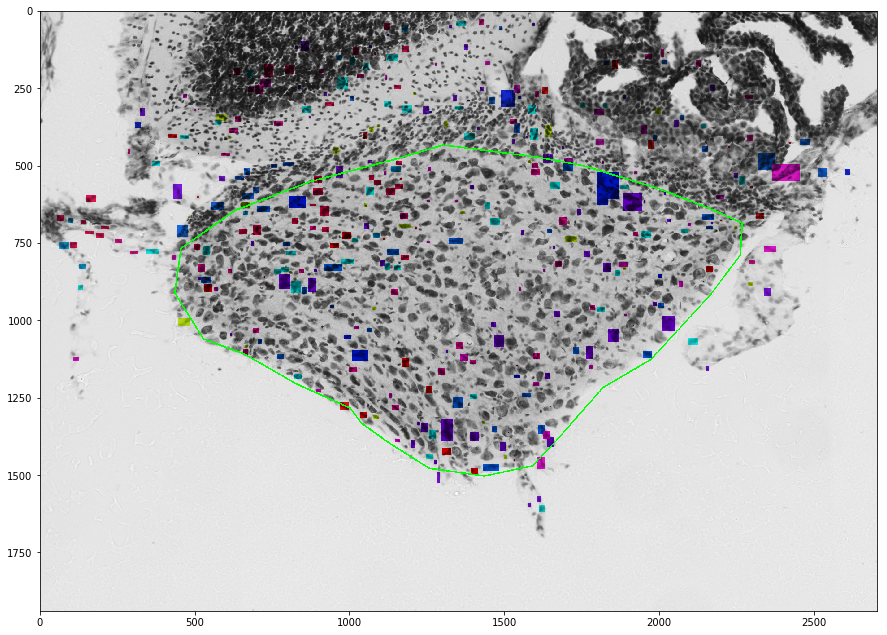

In [156]:
%%time
plt.figure(figsize=(15,15))
rgb = skimage.color.hsv2rgb(hsv)
rgb = rgb * 255
rgb = rgb.astype(np.uint8)
com = cv2.polylines(rgb.copy(), [polygon.astype(np.int32)], True, [0, 255, 0], 3, lineType=8)
plt.imshow(com)

In [15]:
origin= ['area', 'height', 'horiz_std', 'mean', 'padded_size',
       'rotation', 'rotation_confidence', 'std', 'vert_std', 'width', 'density', 'area_ratio']
columns = []
for i in range(10):
    name = 'DMVec'+str(i)
    for j in range(99):
        columns.append(name+'*'+str(j))
for i in range(10):
    name = origin[i]
    for j in range(99):
        columns.append(name+'*'+str(j))
columns.extend(origin[-2:])
columns = np.array(columns)

In [49]:
len(columns)

1982

98 VCA 1 / 1
CPU times: user 9.26 s, sys: 1.12 s, total: 10.4 s
Wall time: 7 s


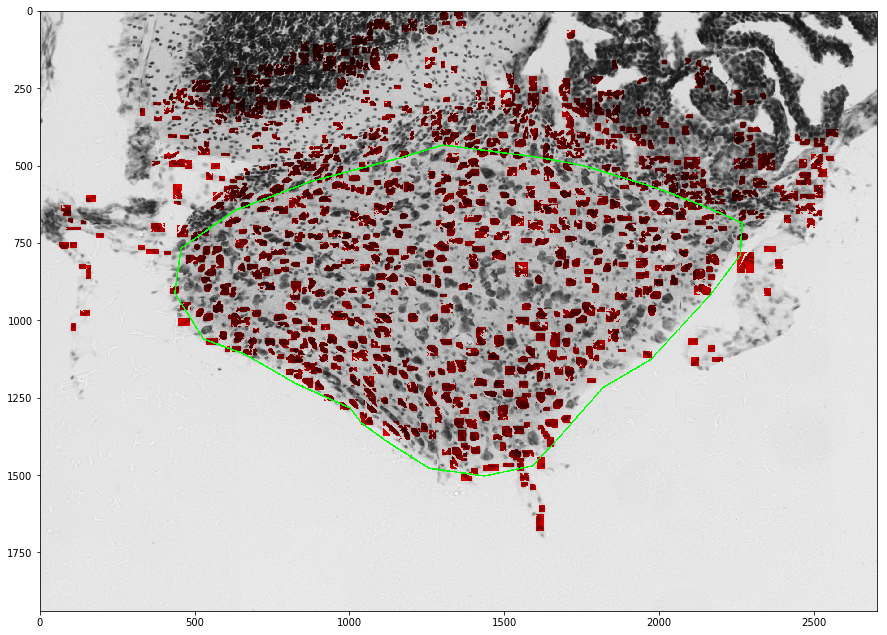

In [27]:
%%time
# hsv = np.zeros([m, n, 3])
# hsv[:, :, 2] = img / 255
count = 0
importances = {}
for contour_id, contour in polygons:
    structure = contour_id
    if structure not in all_structures:
        continue
    polygon = contour.copy()

    if structure == '7n':
        structure = '7nn'

    fp = []
    fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
    fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))

    fp = []
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=columns)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'

    [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 0]) + margin),n)),
                               int(max(min(polygon[:, 1]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 1]) + margin),m))]
    hsv = np.zeros([down-up, right-left, 3])
    hsv[:, :, 2] = img[up:down,left:right] / 255
    mask = cv2.adaptiveThreshold(img[up:down,left:right],1,\
                                         cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 81, -20)
    raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]
    
#     inside_area = Polygon(polygon).area
#     outside_area = Polygon(polygon).buffer(margin, resolution=2).area - inside_area
    
    path = Path(polygon)
    indices_inside = np.where(path.contains_points(locations))[0]
    features_inside = features[indices_inside]
    locations_inside = locations[indices_inside]
    
    surround = Polygon(polygon).buffer(margin, resolution=2)
    path = Path(list(surround.exterior.coords))
    indices_sur = np.where(path.contains_points(locations))[0]
    indices_outside = np.setdiff1d(indices_sur, indices_inside)
    features_outside = features[indices_outside]
    locations_outside = locations[indices_outside]
    
    gains = bst.get_score(importance_type='total_gain')
    importances[structure] = {}
    for feature in gains.keys():
        if feature=='density':
            continue
        else:
            star = feature.rfind('*')
            name = feature[:star]
            if name not in importances[structure].keys():
                importances[structure][name] = {}
            importances[structure][name][feature] = gains[feature]
    features = importances[structure].keys()
    scores = {}
    for feature in features:
        total = np.array([importances[structure][feature][name] for name in importances[structure][feature].keys()]).sum()
        scores[feature] = total
    features_sorted = sorted(scores, key=scores.__getitem__, reverse=True)
    k = 0
    for feature in [features_sorted[0]]:
        for name in importances[structure][feature].keys():
            index = np.where(columns==name)[0][0]
            raw = index // 99
            col = index % 99
            if col==98:
                max_value = thresholds[raw][col]
            else:
                min_value = 200#(thresholds[raw][col] + thresholds[raw][col-1])/2
                max_value = 900#(thresholds[raw][col+1] + thresholds[raw][col])/2
            posi = np.where((features_inside[:,raw]>min_value) & (features_inside[:,raw]<max_value))[0]
#             posi = np.where((features_inside[:,raw]<max_value))[0]
            for cell in posi:
                cx = int(locations_inside[cell, 0])
                cy = int(locations_inside[cell, 1])
                height = int(features_inside[cell, 11]/2)
                width = int(features_inside[cell, 19]/2)
                hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 0] = \
                1.0/30*k*mask[cy-height-up:cy+height-up, cx-width-left:cx+width-left]
                hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 1] = \
                mask[cy-height-up:cy+height-up, cx-width-left:cx+width-left]

            nega = np.where((features_outside[:,raw]>min_value) & (features_outside[:,raw]<max_value))[0]
#             nega = np.where((features_outside[:,raw]<max_value))[0]
            for cell in nega:
                cx = int(locations_outside[cell, 0])
                cy = int(locations_outside[cell, 1])
                height = int(features_outside[cell, 11]/2)
                width = int(features_outside[cell, 19]/2)
                hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 0] = \
                1.0/30*k*mask[cy-height-up:cy+height-up, cx-width-left:cx+width-left]
                hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 1] = \
                mask[cy-height-up:cy+height-up, cx-width-left:cx+width-left]
        k += 1
    polygon[:, 0] = polygon[:, 0] - left
    polygon[:, 1] = polygon[:, 1] - up
    plt.figure(figsize=(15,15))
    rgb = skimage.color.hsv2rgb(hsv)
    rgb = rgb * 255
    rgb = rgb.astype(np.uint8)
    com = cv2.polylines(rgb.copy(), [polygon.astype(np.int32)], True, [0, 255, 0], 3, lineType=8)
    plt.imshow(com)
    count += 1
    print(section, structure, count, '/', len(polygons))

In [28]:
com.shape

(1939, 2704, 3)

area_ratio 2 VCP
area_ratio 0 DC
CPU times: user 27 s, sys: 1.06 s, total: 28.1 s
Wall time: 15.3 s


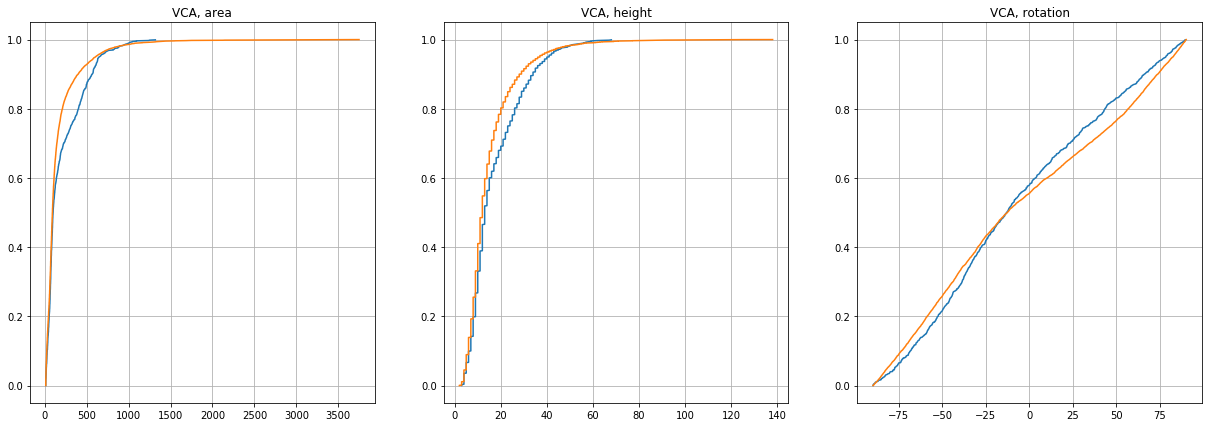

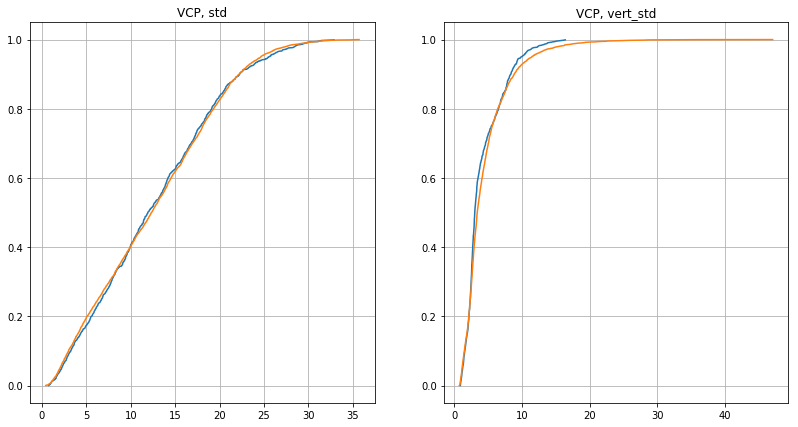

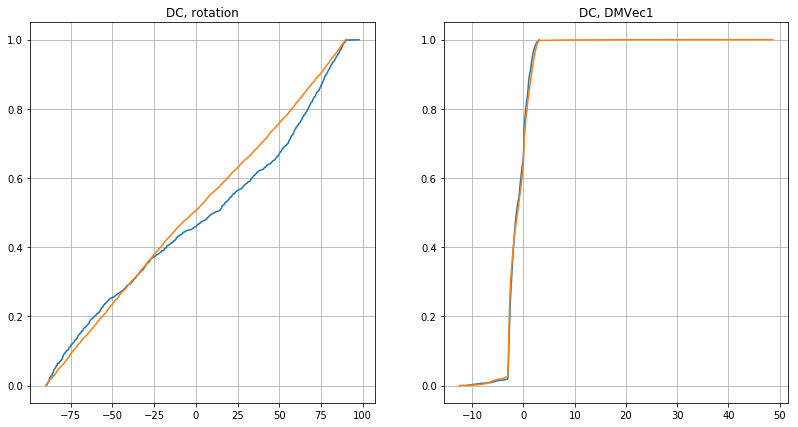

In [16]:
%%time
count = 0
importances = {}
sort_by_imp = {}
for contour_id, contour in polygons:
    structure = contour_id
    if structure not in all_structures:
        continue
    polygon = contour.copy()

    if structure == '7n':
        structure = '7nn'

    fp = []
    fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
    fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))

    fp = []
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=columns)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'

    [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 0]) + margin),n)),
                               int(max(min(polygon[:, 1]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 1]) + margin),m))]
    
    raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]
    
    
    path = Path(polygon)
    indices_inside = np.where(path.contains_points(locations))[0]
    features_inside = features[indices_inside]
    locations_inside = locations[indices_inside]
    
    surround = Polygon(polygon).buffer(margin, resolution=2)
    path = Path(list(surround.exterior.coords))
    indices_sur = np.where(path.contains_points(locations))[0]
    indices_outside = np.setdiff1d(indices_sur, indices_inside)
    features_outside = features[indices_outside]
    locations_outside = locations[indices_outside]
    
    gains = bst.get_score(importance_type='total_gain')
    importances[structure] = {}
    for feature in gains.keys():
        if feature=='density'or feature=='area_ratio':
            importances[structure][feature] = gains[feature]
        else:
            star = feature.rfind('*')
            name = feature[:star]
            if name not in importances[structure].keys():
                importances[structure][name] = {}
            importances[structure][name][feature] = gains[feature]
    features = importances[structure].keys()
    scores = {}
    for feature in features:
        if feature=='density'or feature=='area_ratio':
            scores[feature] = importances[structure][feature]
        else:
            total = np.array([importances[structure][feature][name] for name in importances[structure][feature].keys()]).sum()
            scores[feature] = total
    features_sorted = sorted(scores, key=scores.__getitem__, reverse=True)
    sort_by_imp[structure] = features_sorted[:5]
    plt.figure(figsize=(21,7))
    for i in range(3):
        feature = features_sorted[i]
        if feature!='density'and feature!='area_ratio':
            most = list(importances[structure][feature].keys())[0]
            index = np.where(columns==most)[0][0]
            raw = index // 99
            plt.subplot(1,3,i+1)
            x,y = CDF(features_inside[:,raw])
            plt.plot(x,y)
            x,y = CDF(features_outside[:,raw])
            plt.plot(x,y)
            plt.grid(True)
            plt.title(structure+', '+feature)
        else:
            print(feature, i, structure)

run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_databases/MD594/157.db /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/157.db
run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_databases/MD594/247.db /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/247.db
run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_databases/MD594/293.db /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/293.db
run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_databases/MD594/256.db /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/256.db
area_ratio 0 7n
run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_databases/MD594/172.db /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/172.db
run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_databases/MD594/188.db /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/188.db
run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_databases/MD594/285.db /Users/kuiqian/BstemAtl

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_databases/MD594/118.db /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/118.db
ALREADY DOWNLOADED FILE
area_ratio 0 DC
ALREADY DOWNLOADED FILE
run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_databases/MD594/225.db /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/225.db
area_ratio 2 12N
ALREADY DOWNLOADED FILE
area_ratio 1 RtTg
run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_databases/MD594/196.db /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/196.db
area_ratio 1 SC
density 2 SC
run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_databases/MD594/286.db /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_databases/MD594/286.db
area_ratio 1 IC
CPU times: user 9min 13s, sys: 11.6 s, total: 9min 24s
Wall time: 6min 16s


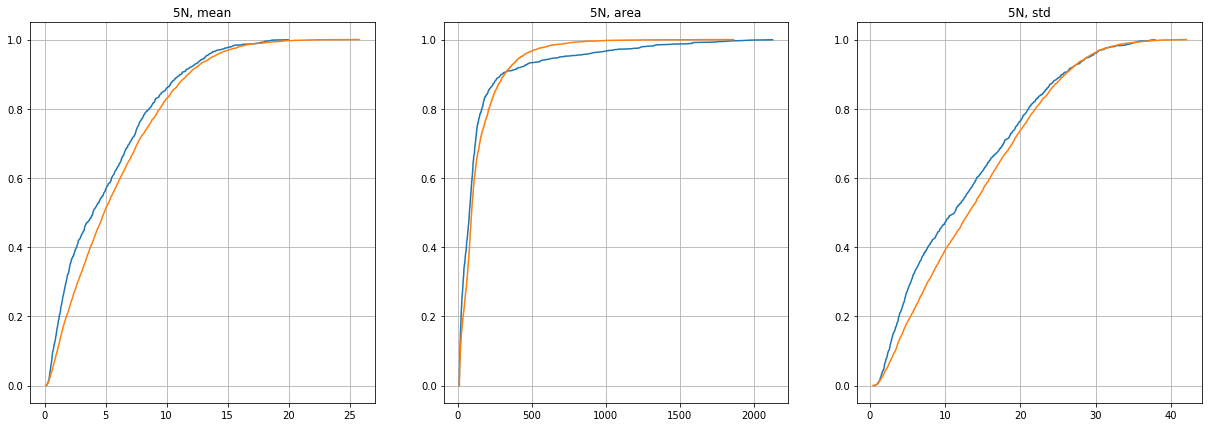

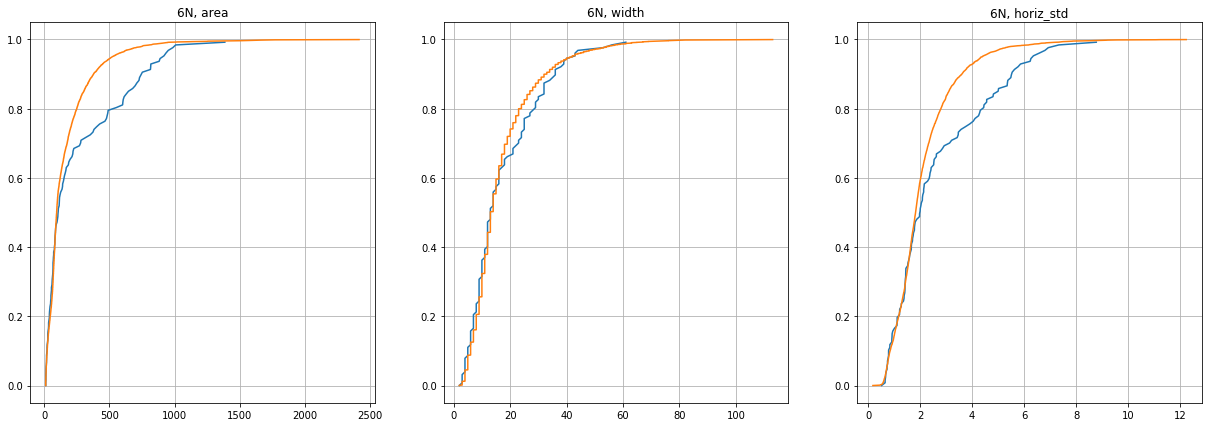

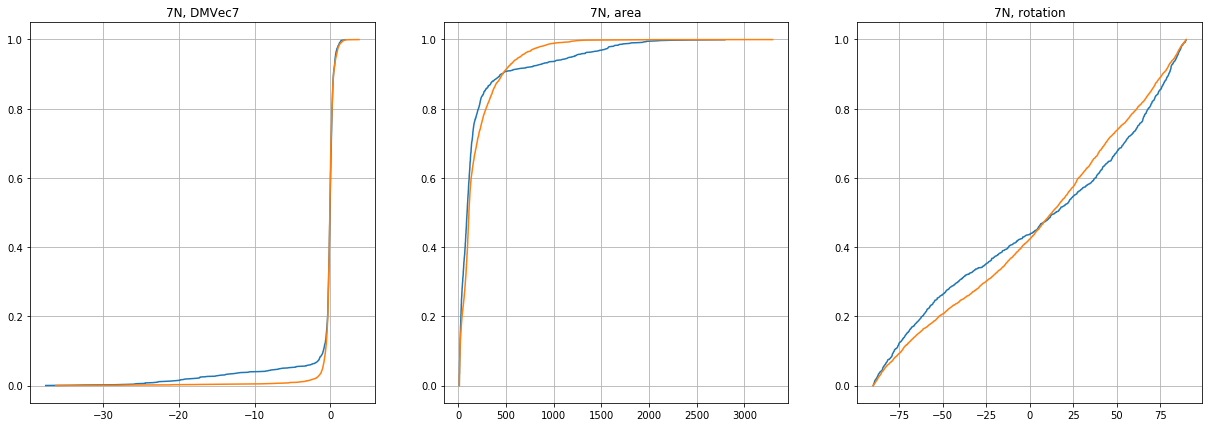

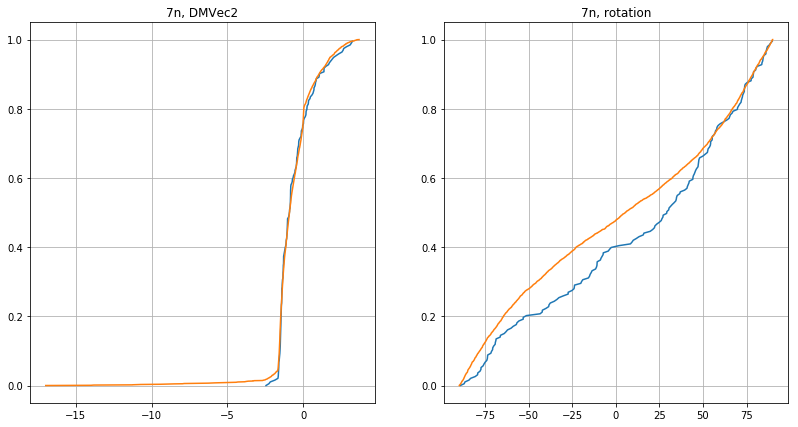

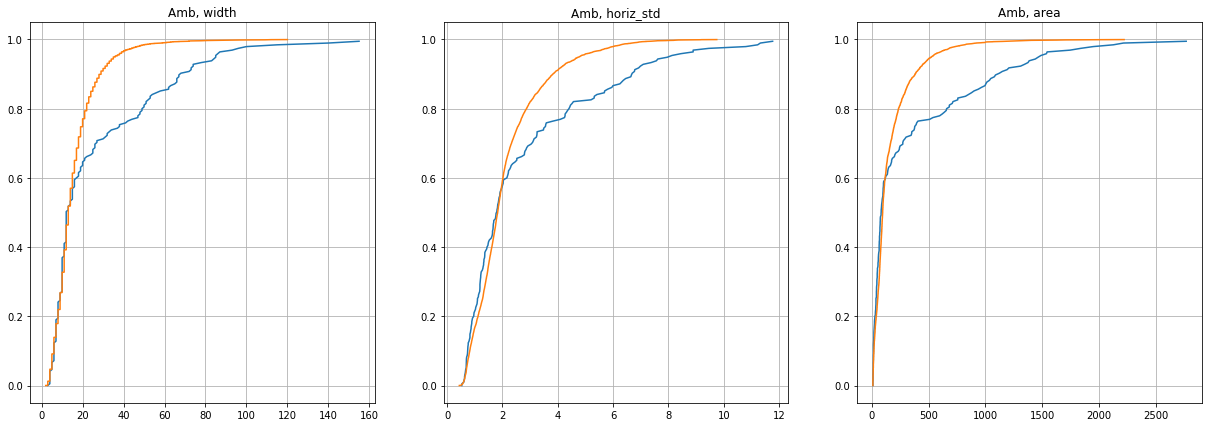

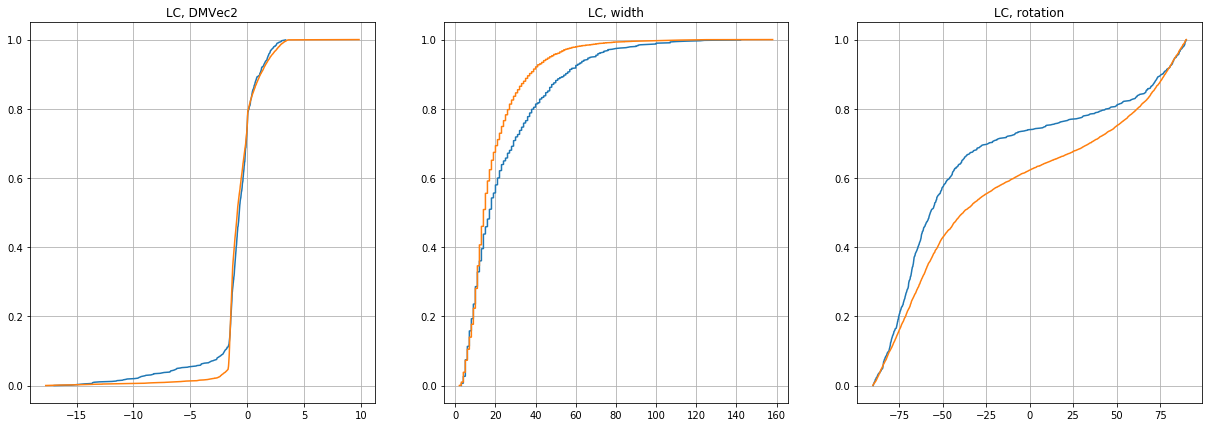

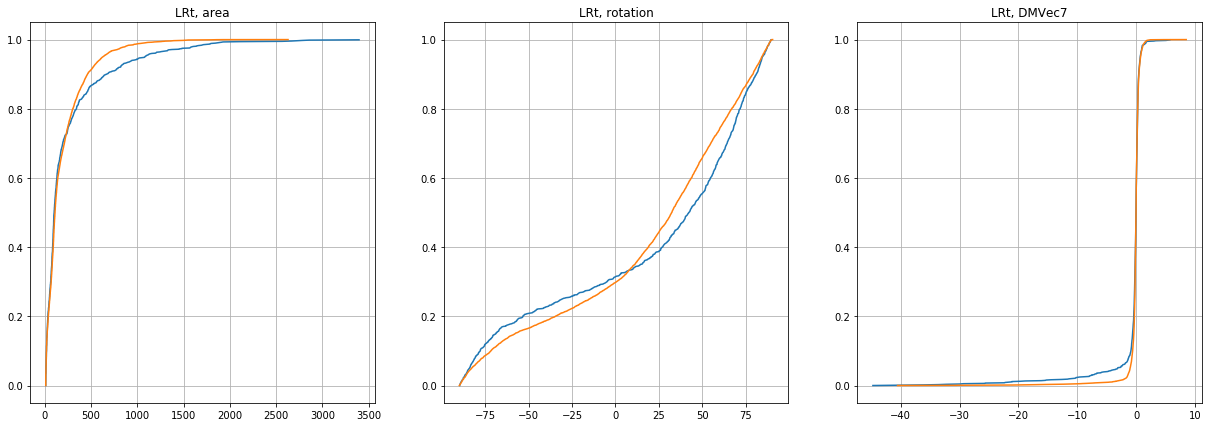

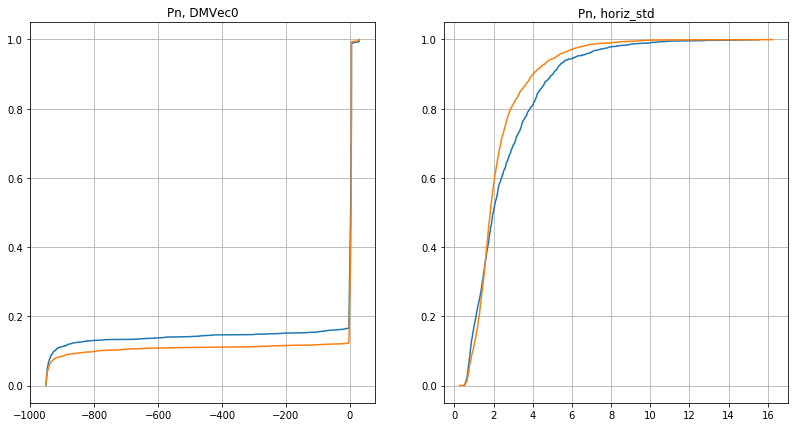

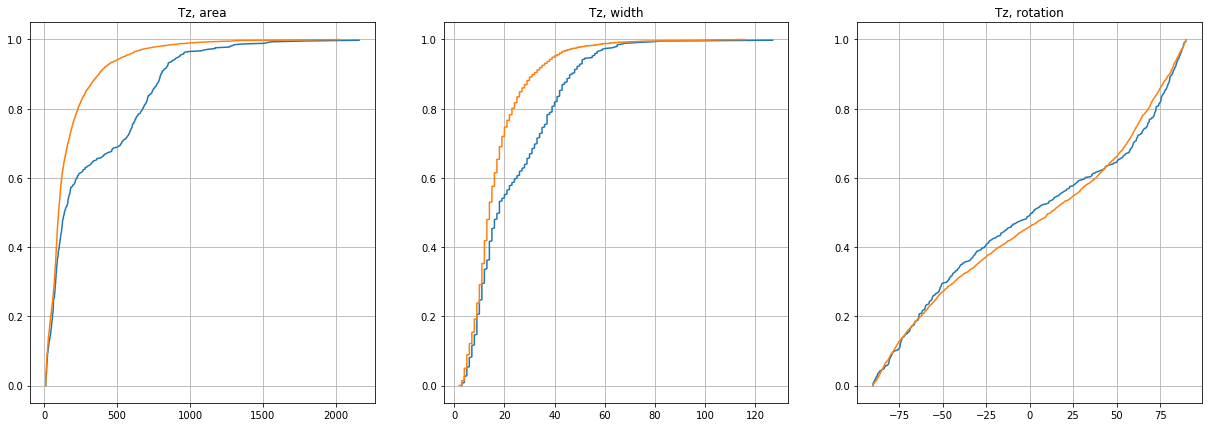

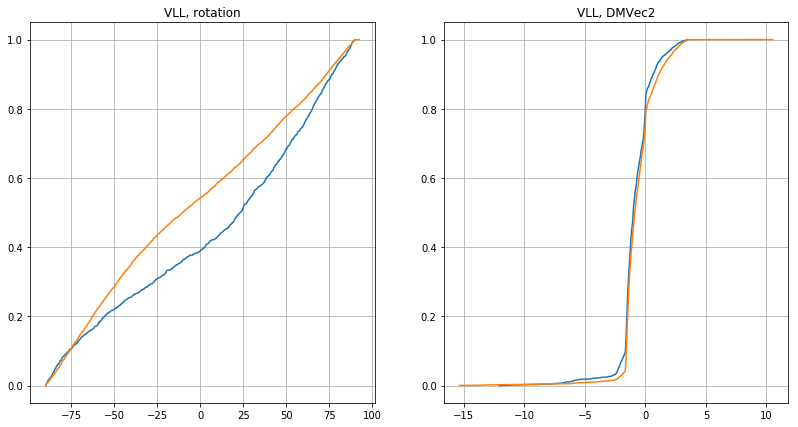

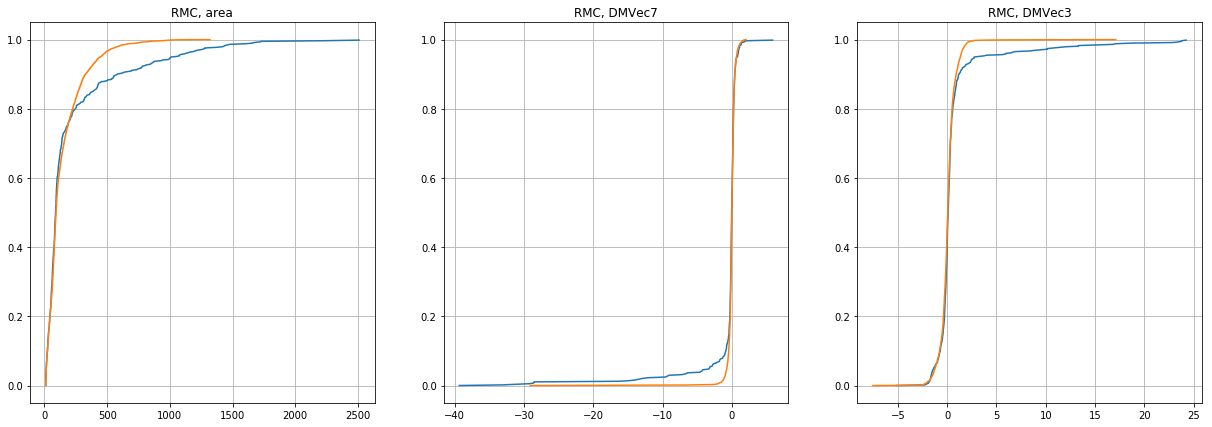

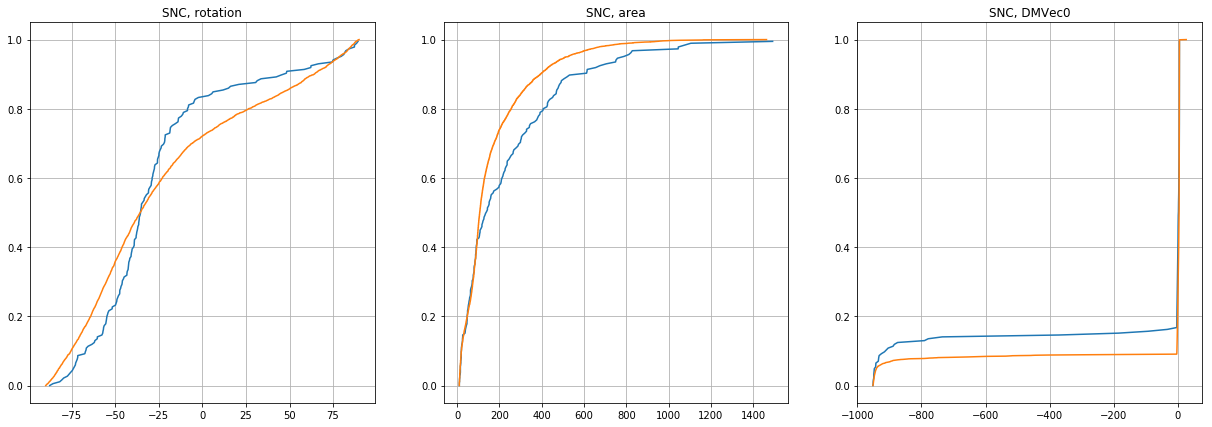

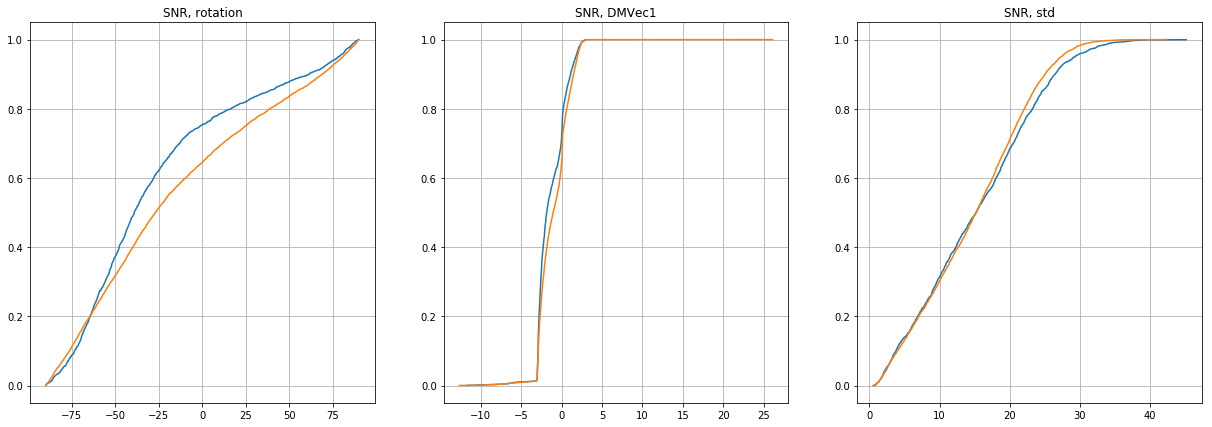

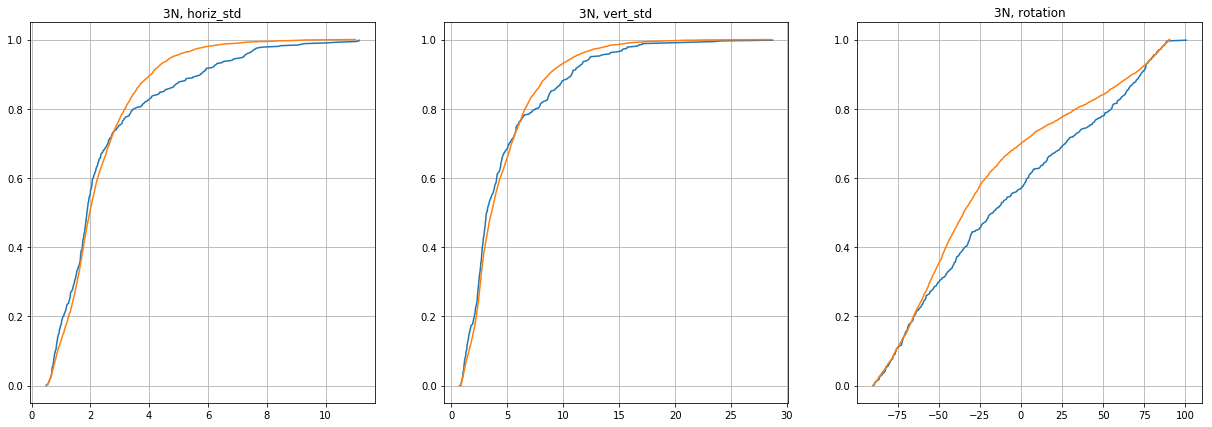

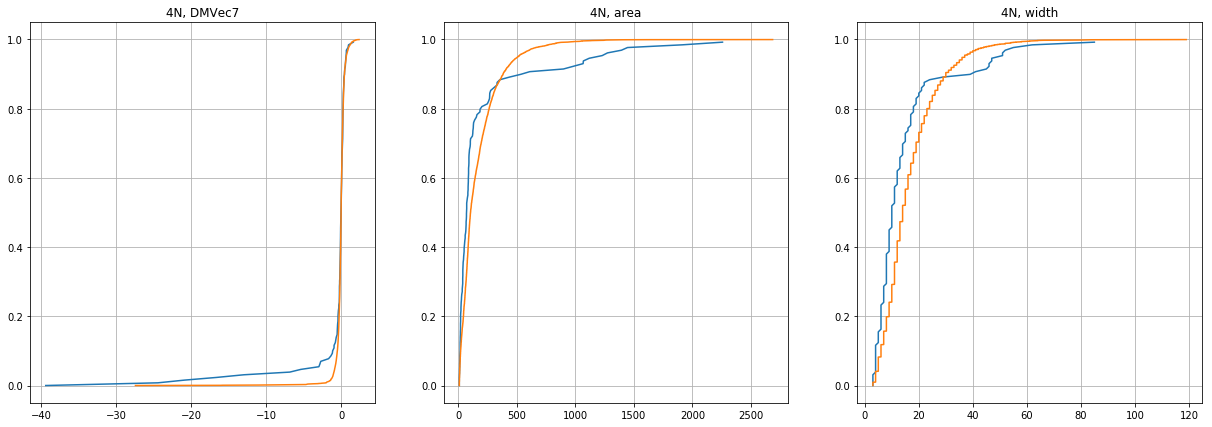

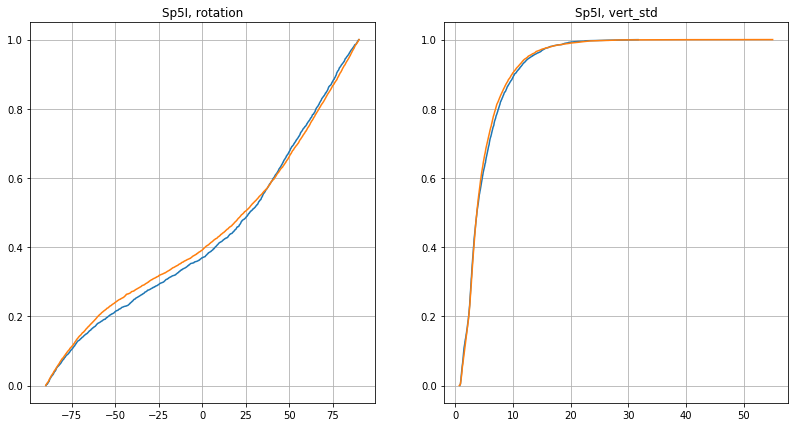

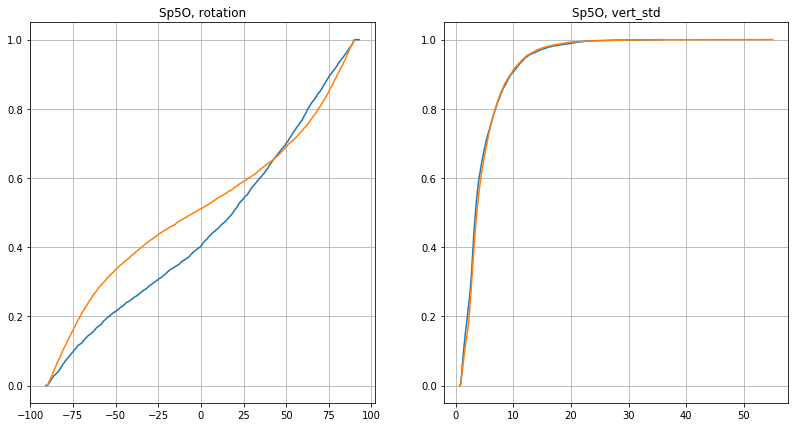

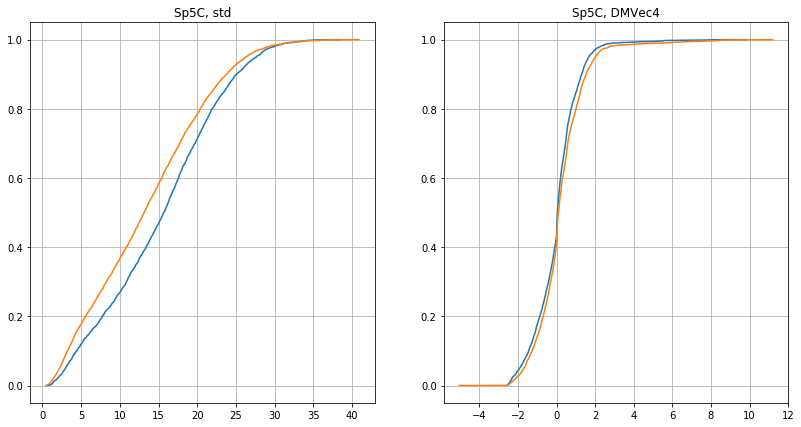

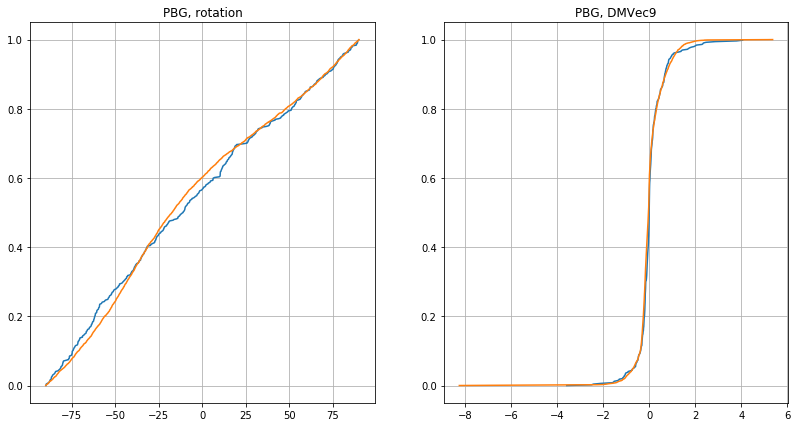

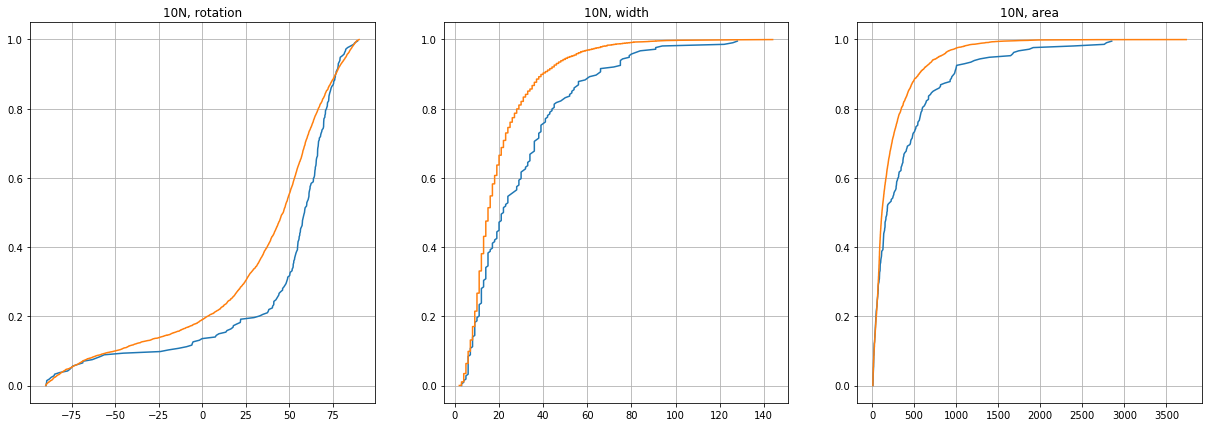

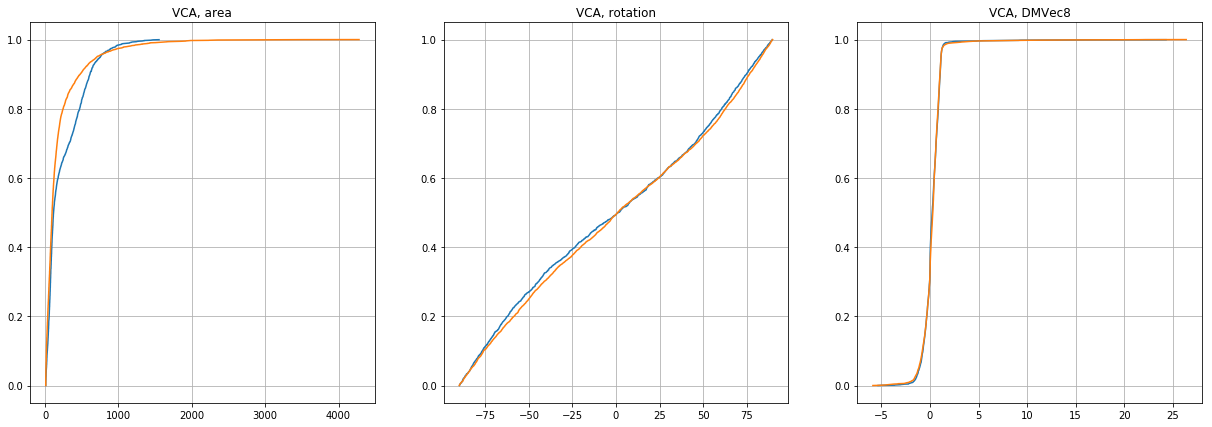

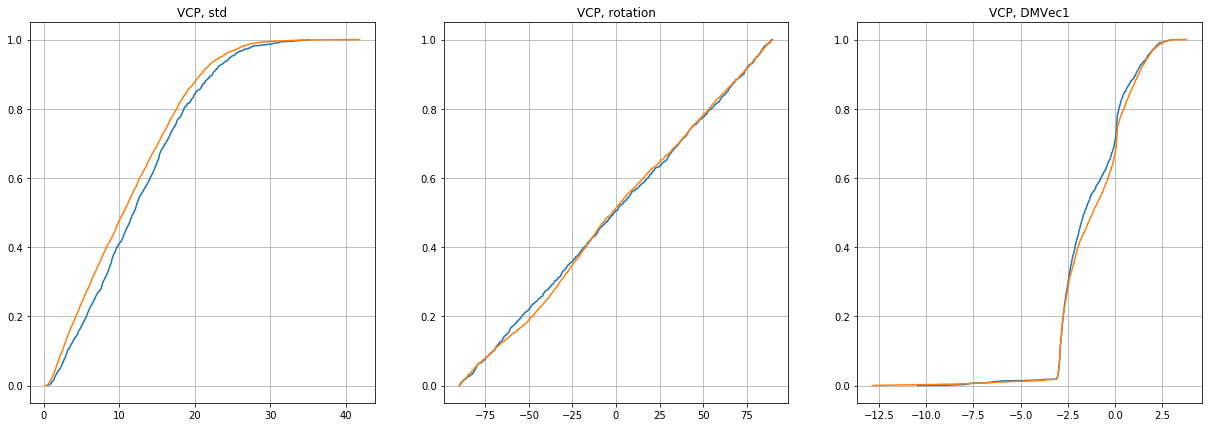

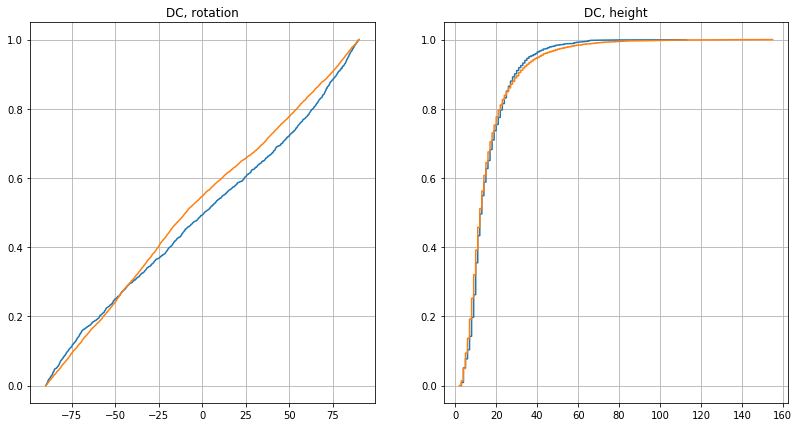

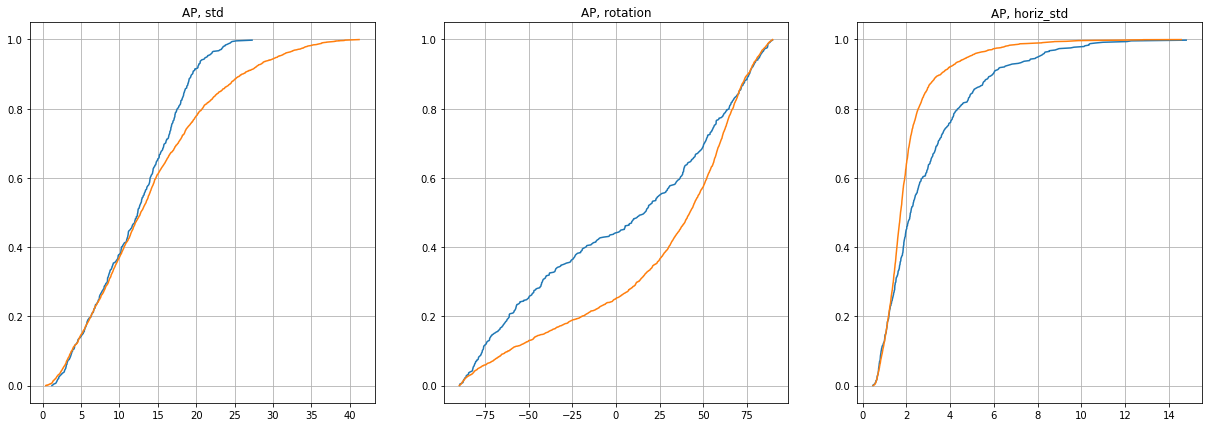

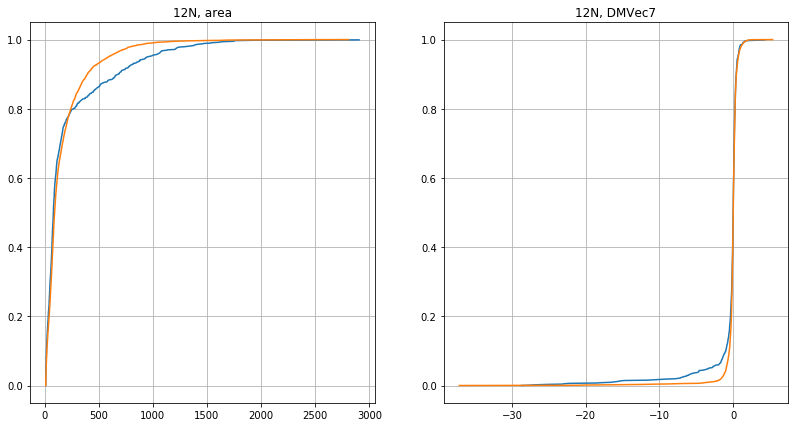

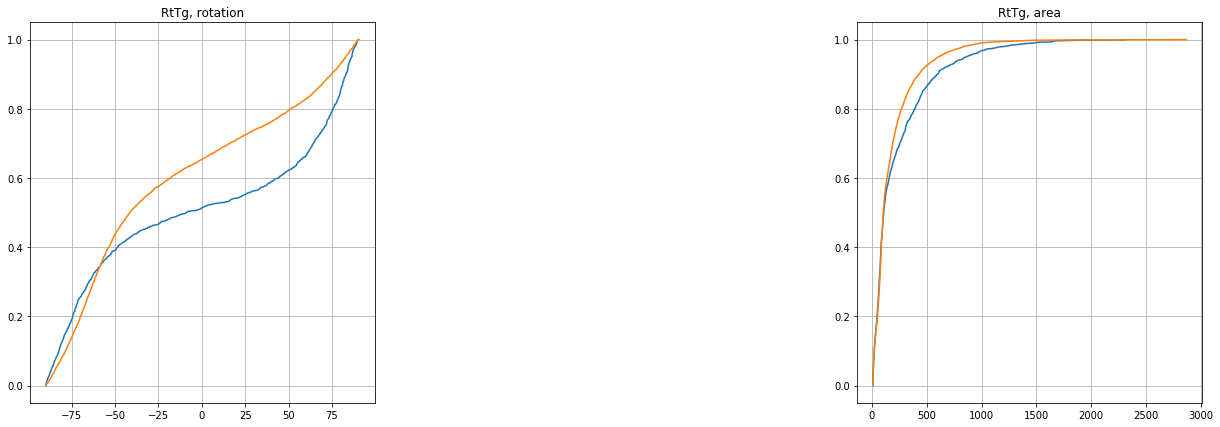

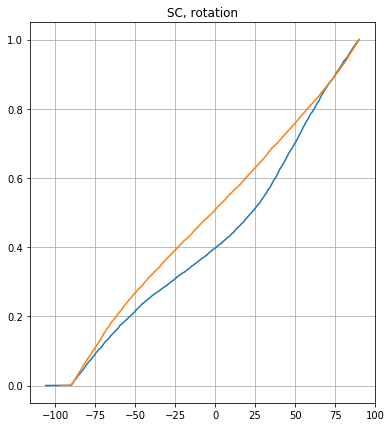

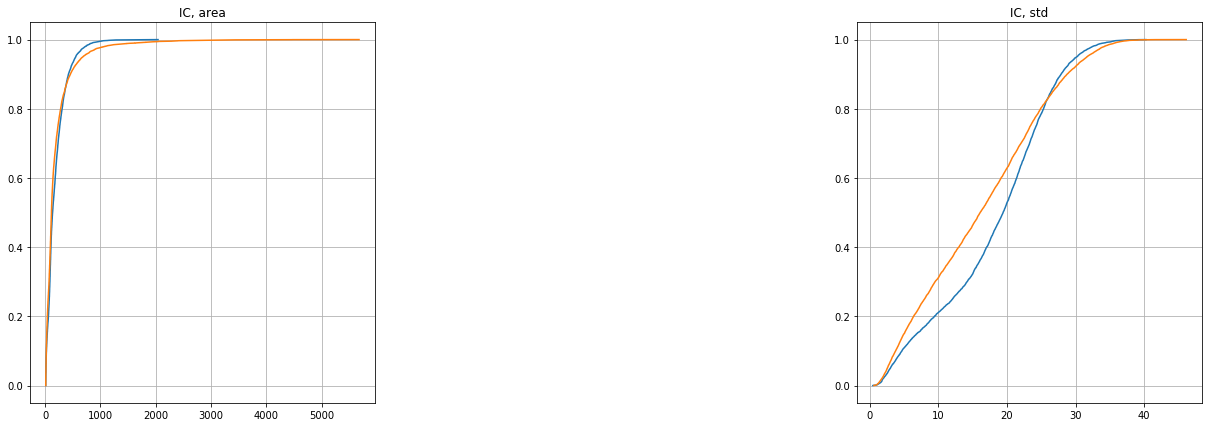

In [24]:
%%time
count = 0
importances = {}
sort_by_imp = {}
for structure in all_structures:
    if structure == '7n':
        structure = '7nn'

    fp = []
    fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
    fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))

    fp = []
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=columns)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'
    
    polygons = [(contour['section'], contour['vertices']) \
                for contour_id, contour in contours_struc.get_group(structure).iterrows()]
    area_max = 0
    for contour_id, contour in polygons:
        section = contour_id
        polygon = contour.copy()
        if Polygon(polygon).area>area_max:
            area_max = Polygon(polygon).area
            section_max = section
            polygon_max = polygon 
    polygon = polygon_max
    
    db_dir = 'CSHL_databases/' + stack + '/'
    db_fp = db_dir + str(section_max) + '.db'
    setup_download_from_s3(db_fp, recursive=False)
    conn = sqlite3.connect(os.environ['ROOT_DIR']+ db_fp)
    cur = conn.cursor()   
    
    [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 0]) + margin),n)),
                               int(max(min(polygon[:, 1]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 1]) + margin),m))]
    
    raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]
    
    
    path = Path(polygon)
    indices_inside = np.where(path.contains_points(locations))[0]
    features_inside = features[indices_inside]
    locations_inside = locations[indices_inside]
    
    surround = Polygon(polygon).buffer(margin, resolution=2)
    path = Path(list(surround.exterior.coords))
    indices_sur = np.where(path.contains_points(locations))[0]
    indices_outside = np.setdiff1d(indices_sur, indices_inside)
    features_outside = features[indices_outside]
    locations_outside = locations[indices_outside]
    
    gains = bst.get_score(importance_type='total_gain')
    importances[structure] = {}
    for feature in gains.keys():
        if feature=='density'or feature=='area_ratio':
            importances[structure][feature] = gains[feature]
        else:
            star = feature.rfind('*')
            name = feature[:star]
            if name not in importances[structure].keys():
                importances[structure][name] = {}
            importances[structure][name][feature] = gains[feature]
    features = importances[structure].keys()
    scores = {}
    for feature in features:
        if feature=='density'or feature=='area_ratio':
            scores[feature] = importances[structure][feature]
        else:
            total = np.array([importances[structure][feature][name] for name in importances[structure][feature].keys()]).sum()
            scores[feature] = total
    features_sorted = sorted(scores, key=scores.__getitem__, reverse=True)
    sort_by_imp[structure] = features_sorted[:5]
    plt.figure(figsize=(21,7))
    for i in range(3):
        feature = features_sorted[i]
        if feature!='density'and feature!='area_ratio':
            most = list(importances[structure][feature].keys())[0]
            index = np.where(columns==most)[0][0]
            raw = index // 99
            plt.subplot(1,3,i+1)
            x,y = CDF(features_inside[:,raw])
            plt.plot(x,y)
            x,y = CDF(features_outside[:,raw])
            plt.plot(x,y)
            plt.grid(True)
            plt.title(structure+', '+feature)
        else:
            print(feature, i, structure)

In [25]:
holds = {}
holds['5N'] = {}
holds['5N']['mean'] = [[2,11]]
holds['5N']['area'] = [[120,1500]]
holds['5N']['std'] = [[3,22]]
holds['6N'] = {}
holds['6N']['area'] = [[130, 1000]]
holds['6N']['width'] = [[16, 40]]
holds['6N']['horiz_std'] = [[2, 7]]
holds['7N'] = {}
holds['7N']['DMVec7'] = [[-25, -1]]
holds['7N']['area'] = [[120, 1800]]
holds['7N']['rotation'] = [[-70, -10], [30, 70]]
holds['7n'] = {}
holds['7n']['DMVec2'] = [[-3,-1]]
holds['7n']['rotation'] = [[-75, 50]]
holds['Amb'] = {}
holds['Amb']['width'] = [[16, 110]]
holds['Amb']['horiz_std'] = [[2, 9]]
holds['Amb']['area'] = [[100, 2000]]
holds['LC'] = {}
holds['LC']['DMVec2'] = [[-13, -2]]
holds['LC']['width'] = [[16, 100]]
holds['LC']['rotation'] = [[-75, 75]]
holds['LRt'] = {}
holds['LRt']['area'] = [[270, 1900]]
holds['LRt']['rotation'] = [[-75, 75]]
holds['LRt']['DMVec7'] = [[-25, 1]]
holds['Pn'] = {}
holds['Pn']['DMVec0'] = [[-950, 0]]
holds['Pn']['horiz_std'] = [[2, 10]]
holds['Tz'] = {}
holds['Tz']['area'] = [[100, 1300]]
holds['Tz']['width'] = [[16, 60]]
holds['Tz']['rotation'] = [[-50, 75]]
holds['VLL'] = {}
holds['VLL']['rotation'] = [[-62, 70]]
holds['VLL']['DMVec2'] = [[-7, -1.5], [0, 3.5]]
holds['RMC'] = {}
holds['RMC']['area'] = [[230, 1300]]
holds['RMC']['DMVec7'] = [[-30, 1]]
holds['RMC']['DMVec3'] = [[1, 17]]
holds['SNC'] = {}
holds['SNC']['rotation'] = [[-75,75]]
holds['SNC']['area'] = [[90, 1100]]
holds['SNC']['DMVec0'] = [[-950, 0]]
holds['SNR'] = {}
holds['SNR']['rotation'] = [[-50, 75]]
holds['SNR']['DMVec1'] = [[-3,2]]
holds['SNR']['std'] = [[18, 34]]
holds['3N'] = {}
holds['3N']['horiz_std'] = [[3, 9]]
holds['3N']['vert_std'] = [[6, 17]]
holds['3N']['rotation'] = [[-50, 75]]
holds['4N'] = {}
holds['4N']['DMVec7'] = [[-28, -1]]
holds['4N']['area'] = [[100, 2000]]
holds['4N']['width'] = [[2, 50]]
holds['Sp5I'] = {}
holds['Sp5I']['rotation'] = [[-60, 30]]
holds['Sp5I']['vert_std'] = [[5,14]]
holds['Sp5O'] = {}
holds['Sp5O']['rotation'] = [[-75, 50]]
holds['Sp5O']['vert_std'] = [[1,6]]
holds['Sp5C'] = {}
holds['Sp5C']['std'] = [[1, 28]]
holds['Sp5C']['DMVec4'] = [[-2, 2]]
holds['PBG'] = {}
holds['PBG']['rotation'] = [[-75, -40], [-25, 20]]
holds['PBG']['DMVec9'] = [[0.8, 2.3]]
holds['10N'] = {}
holds['10N']['rotation'] = [[-50, 75]]
holds['10N']['width'] = [[10, 100]]
holds['10N']['area'] = [[110, 2500]]
holds['VCA'] = {}
holds['VCA']['area'] = [[200,700]]
holds['VCA']['rotation'] = [[-75, -5],[50 ,75]]
holds['VCA']['DMVec8'] = [[1, 4]]
holds['VCP'] = {}
holds['VCP']['std'] = [[2, 30]]
holds['VCP']['rotation'] = [[-65, -25]]
holds['VCP']['DMVec1'] = [[-2.5, 2]]
holds['DC'] = {}
holds['DC']['rotation'] = [[-25, 75]]
holds['DC']['height'] = [[30, 80]]
holds['AP'] = {}
holds['AP']['std'] = [[13, 27]]
holds['AP']['rotation'] = [[-75, 70]]
holds['AP']['horiz_std'] = [[1.5, 10]]
holds['12N'] = {}
holds['12N']['area'] = [[230, 1500]]
holds['12N']['DMVec7'] = [[-20, -1]]
holds['RtTg'] = {}
holds['RtTg']['rotation'] = [[-60, 80]]
holds['RtTg']['area'] = [[120, 1500]]
holds['SC'] = {}
holds['SC']['rotation'] = [[-75, 70]]
holds['IC'] = {}
holds['IC']['area'] = [[400, 2000]]
holds['IC']['std'] = [[2, 25]]

In [117]:
holds

{'VCA': {'area': [[200, 700]], 'height': [[15, 40]], 'rotation': [[-15, 75]]},
 'VCP': {'std': [[23, 30]], 'vert_std': [[7, 16]]},
 'SNR': {'rotation': [[-75, -10], [20, 75]],
  'DMVec1': [[-3, 2]],
  'std': [[4, 21]]},
 'DC': {'rotation': [[-25, 75]], 'DMVec1': [[-2, 2]]}}

In [114]:
sort_by_imp

{'VCA': ['area', 'height', 'rotation', 'DMVec9', 'density'],
 'VCP': ['std', 'vert_std', 'area_ratio', 'DMVec2', 'rotation'],
 'DC': ['area_ratio', 'rotation', 'DMVec1', 'height', 'std']}

115 VCA 1 / 3
115 VCP 2 / 3
115 DC 3 / 3
CPU times: user 11.6 s, sys: 2.09 s, total: 13.7 s
Wall time: 13.2 s


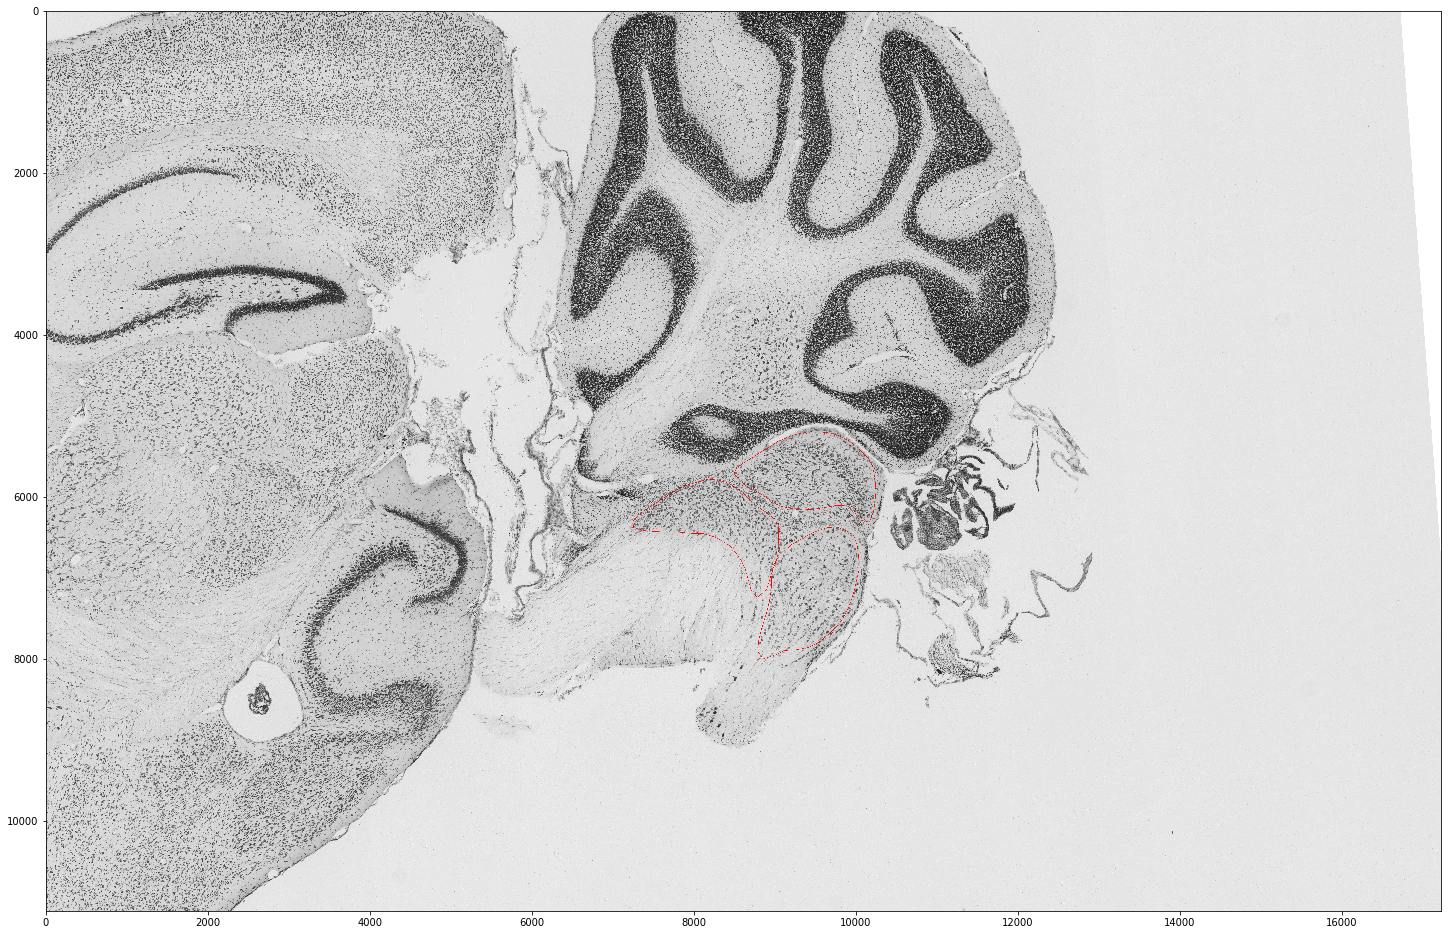

In [8]:
%%time
whole = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
count = 0    
k = 0
cs = []
for contour_id, contour in polygons:
    structure = contour_id
    if structure not in all_structures:
        continue
    polygon = contour.copy()

#     [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
#                                int(min(np.ceil(max(polygon[:, 0]) + margin),n)),
#                                int(max(min(polygon[:, 1]) - margin, 0)),
#                                int(min(np.ceil(max(polygon[:, 1]) + margin),m))]
#     hsv = np.zeros([down-up, right-left, 3])
#     hsv[:, :, 2] = img[up:down,left:right] / 255
#     mask = cv2.adaptiveThreshold(img[up:down,left:right],1,\
#                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 81, -20)
#     raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
#     info = np.array(list(raws))
#     locations = info[:, 1:3]
#     features = info[:, 3:]
    
#     path = Path(polygon)
#     indices_inside = np.where(path.contains_points(locations))[0]
#     features_inside = features[indices_inside]
#     locations_inside = locations[indices_inside]
    
#     surround = Polygon(polygon).buffer(margin, resolution=2)
#     path = Path(list(surround.exterior.coords))
#     indices_sur = np.where(path.contains_points(locations))[0]
#     indices_outside = np.setdiff1d(indices_sur, indices_inside)
#     features_outside = features[indices_outside]
#     locations_outside = locations[indices_outside]

#     features_sorted = sort_by_imp[structure]
#     for feature in [features_sorted[0]]:
#         name = list(importances[structure][feature].keys())[0]
#         index = np.where(columns==name)[0][0]
#         raw = index // 99

#         min_value = holds[structure][0] 
#         max_value = holds[structure][1]
#         posi = np.where((features_inside[:,raw]>min_value) & (features_inside[:,raw]<max_value))[0]
#         for cell in posi:
#             cx = int(locations_inside[cell, 0])
#             cy = int(locations_inside[cell, 1])
#             height = int(features_inside[cell, 11]/2)
#             width = int(features_inside[cell, 19]/2)
#             hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 0] = \
#             1.0/3*k*mask[cy-height-up:cy+height-up, cx-width-left:cx+width-left]
#             hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 1] = \
#             mask[cy-height-up:cy+height-up, cx-width-left:cx+width-left]

#         nega = np.where((features_outside[:,raw]>min_value) & (features_outside[:,raw]<max_value))[0]
#         for cell in nega:
#             cx = int(locations_outside[cell, 0])
#             cy = int(locations_outside[cell, 1])
#             height = int(features_outside[cell, 11]/2)
#             width = int(features_outside[cell, 19]/2)
#             hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 0] = \
#             1.0/3*k*mask[cy-height-up:cy+height-up, cx-width-left:cx+width-left]
#             hsv[cy-height-up:cy+height-up, cx-width-left:cx+width-left, 1] = \
#             mask[cy-height-up:cy+height-up, cx-width-left:cx+width-left]
#         k += 1
#     rgb = skimage.color.hsv2rgb(hsv)
#     rgb = rgb * 255
#     rgb = rgb.astype(np.uint8)
#     whole[up:down, left:right, :] = rgb
    cs.append(polygon.astype(np.int32))
    count += 1
    print(section, structure, count, '/', len(polygons))
plt.figure(figsize=(25,25))
com = cv2.polylines(whole.copy(), cs, True, [255, 0, 0], 3, lineType=50)
plt.imshow(com)
filename = savepath + str(section) + '.tif'
com = cv2.cvtColor(com, cv2.COLOR_BGR2RGB)
cv2.imwrite(os.environ['ROOT_DIR']+filename, com)    

115 VCA 1 / 3
115 VCP 2 / 3
115 DC 3 / 3
CPU times: user 1min 4s, sys: 26.3 s, total: 1min 30s
Wall time: 1min 46s


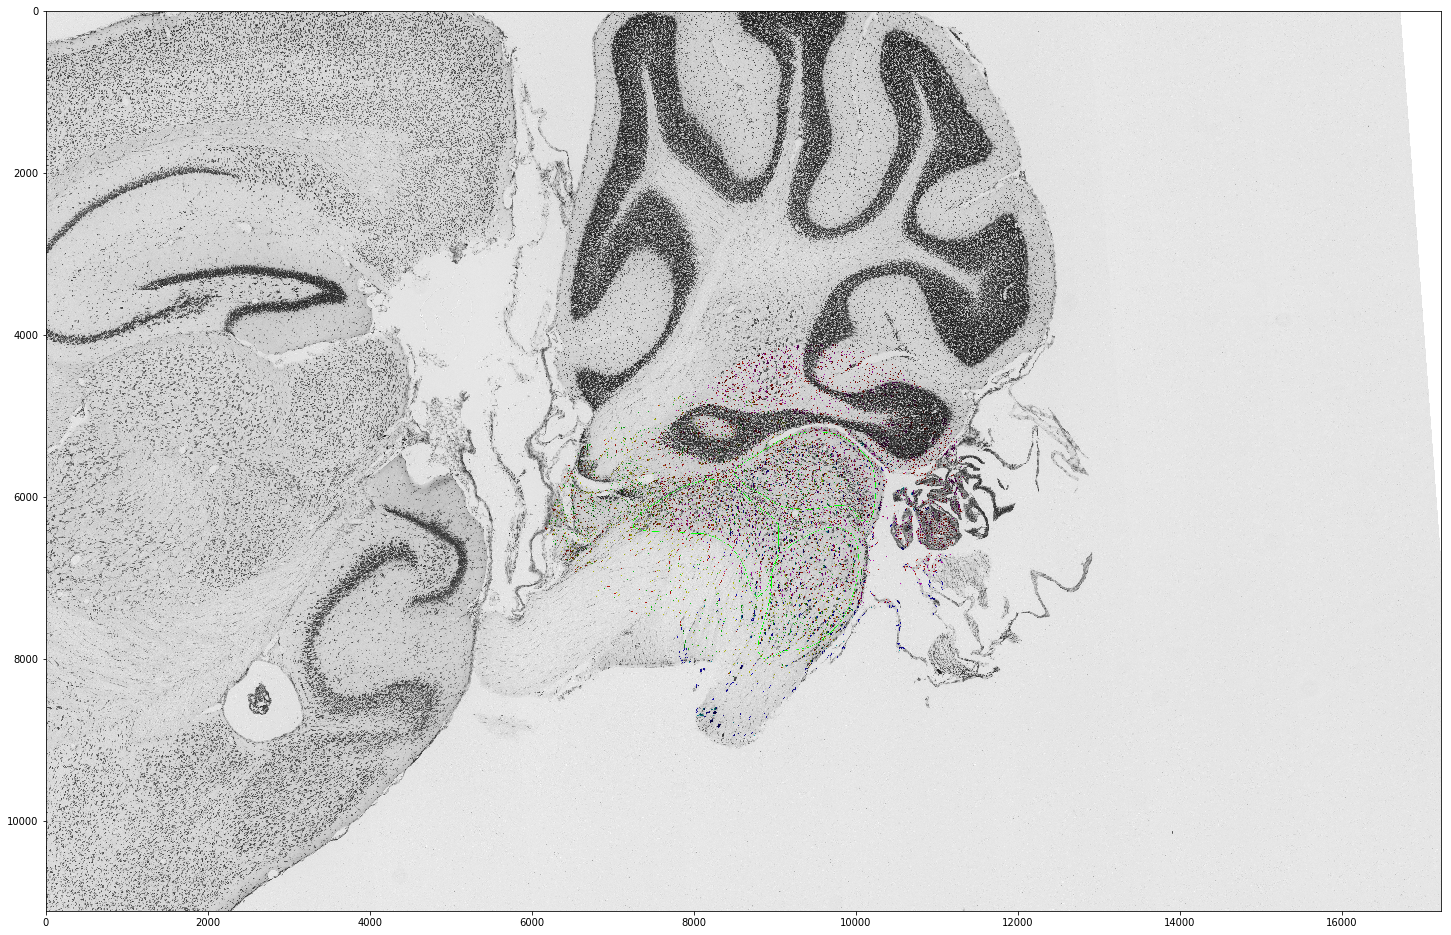

In [177]:
%%time
whole = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
hsv = np.zeros([m, n, 3])
hsv[:, :, 2] = img / 255
thresh = cv2.adaptiveThreshold(255-img, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, -20)
Stats = cv2.connectedComponentsWithStats(thresh)
mask = np.array((Stats[1]>0),dtype=np.uint8)
bboxs = []
count = 0    
k = 0
cs = []
for contour_id, contour in polygons:
    structure = contour_id
    if structure not in all_structures:
        continue
    polygon = contour.copy()
    
    if structure == '7n':
        structure = '7nn'

    fp = []
    fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
    fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))

    fp = []
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=columns)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'
    
    [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 0]) + margin),n)),
                               int(max(min(polygon[:, 1]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 1]) + margin),m))]
    bboxs.append([left, right, up, down])
    
    raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]
    
#     inside_area = Polygon(polygon).area
#     outside_area = Polygon(polygon).buffer(margin, resolution=2).area - inside_area
    
    path = Path(polygon)
    indices_inside = np.where(path.contains_points(locations))[0]
    features_inside = features[indices_inside]
    locations_inside = locations[indices_inside]
    
    surround = Polygon(polygon).buffer(margin, resolution=2)
    path = Path(list(surround.exterior.coords))
    indices_sur = np.where(path.contains_points(locations))[0]
    indices_outside = np.setdiff1d(indices_sur, indices_inside)
    features_outside = features[indices_outside]
    locations_outside = locations[indices_outside]

    features_sorted = sort_by_imp[structure]
    for feature in features_sorted[:3]:
        if feature!='density'and feature!='area_ratio':
            name = list(importances[structure][feature].keys())[0]
            index = np.where(columns==name)[0][0]
            raw = index // 99
            for i in range(len(holds[structure][feature])):
                min_value = holds[structure][feature][i][0] 
                max_value = holds[structure][feature][i][1]
                posi = np.where((features_inside[:,raw]>min_value) & (features_inside[:,raw]<max_value))[0]
                for cell in posi:
                    height = int(features_inside[cell, 11])
                    width = int(features_inside[cell, 19])
                    cx = int(locations_inside[cell, 0]-width/2.0)
                    cy = int(locations_inside[cell, 1]-height/2.0)

                    if len(np.unique(hsv[cy:cy+height, cx:cx+width, 0]))==1:
                        hsv[cy:cy+height, cx:cx+width, 0] = (1.0/len(polygons)*k/2+0.01)*mask[cy:cy+height, cx:cx+width]
                        hsv[cy:cy+height, cx:cx+width, 1] = 0.9*mask[cy:cy+height, cx:cx+width]
                    else:
                        colors = np.unique(hsv[cy:cy+height, cx:cx+width, 0])
                        colors = colors[1:]
                        cols = int(width/(len(colors)+1))
                        pattern = np.ones([1, width])/len(polygons)*k/2
                        pattern[0, :cols*len(colors)] = np.repeat(colors, cols)
                        pattern = np.ones([height, width])*pattern
                        hsv[cy:cy+height, cx:cx+width, 0] = pattern*mask[cy:cy+height, cx:cx+width]

                nega = np.where((features_outside[:,raw]>min_value) & (features_outside[:,raw]<max_value))[0]
                for cell in nega:
                    height = int(features_outside[cell, 11])
                    width = int(features_outside[cell, 19])
                    cx = int(locations_outside[cell, 0]-width/2.0)
                    cy = int(locations_outside[cell, 1]-height/2.0)

                    if len(np.unique(hsv[cy:cy+height, cx:cx+width, 0]))==1:
                        hsv[cy:cy+height, cx:cx+width, 0] = (1.0/len(polygons)*k/2+0.01)*mask[cy:cy+height, cx:cx+width]
                        hsv[cy:cy+height, cx:cx+width, 1] = 0.9*mask[cy:cy+height, cx:cx+width]
                    else:
                        colors = np.unique(hsv[cy:cy+height, cx:cx+width, 0])
                        colors = colors[1:]
                        cols = int(width/(len(colors)+1))
                        pattern = np.ones([1, width])/len(polygons)*k/2
                        pattern[0, :cols*len(colors)] = np.repeat(colors, cols)
                        pattern = np.ones([height, width])*pattern
                        hsv[cy:cy+height, cx:cx+width, 0] = pattern*mask[cy:cy+height, cx:cx+width]
                k += 1
#         else:
            
    cs.append(polygon.astype(np.int32))
    count += 1
    print(section, structure, count, '/', len(polygons))

for i in range(len(bboxs)):
    left, right, up, down = bboxs[i]
    rgb = skimage.color.hsv2rgb(hsv[up:down, left:right, :])
    rgb = rgb * 255
    rgb = rgb.astype(np.uint8)
    whole[up:down, left:right, :] = rgb
plt.figure(figsize=(25,25))
com = cv2.polylines(whole.copy(), cs, True, [0, 255, 0], 3, lineType=15)
plt.imshow(com)
filename = savepath + str(section) + '.tif'
com = cv2.cvtColor(com, cv2.COLOR_BGR2RGB)
cv2.imwrite(os.environ['ROOT_DIR']+filename, com)    

CPU times: user 11.2 s, sys: 1.21 s, total: 12.4 s
Wall time: 11.3 s


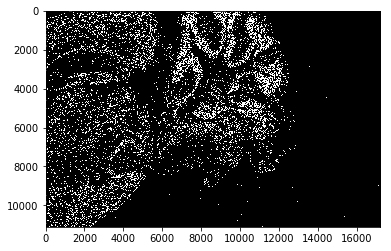

In [155]:
%%time
thresh = cv2.adaptiveThreshold(255-img,1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, -20)
Stats = cv2.connectedComponentsWithStats(thresh)
mask = np.array((Stats[1]>0),dtype=np.uint8)
plt.imshow(mask, cmap='gray')
mask = mask * 255
mask = mask.astype(np.uint8)
cv2.imwrite(os.environ['ROOT_DIR']+savepath+'mask.tif', mask)

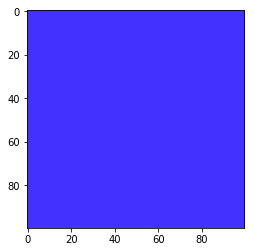

In [12]:
hsv = np.zeros([100, 100, 3])
hsv[:, :, 2] = 1
hsv[:, :, 1] = 0.8
hsv[:, :, 0] = 0.68
plt.imshow(skimage.color.hsv2rgb(hsv))

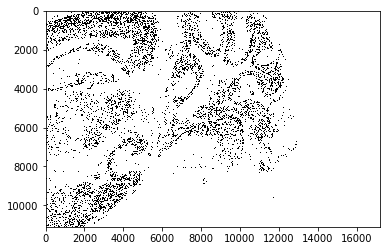

In [150]:
plt.imshow(thresh, cmap='gray')

In [72]:
importances

{'VCA': {'area': {'area*88': 745.833282,
   'area*86': 411.316559,
   'area*87': 284.472748,
   'area*84': 198.141006,
   'area*89': 83.8743515,
   'area*91': 50.271965,
   'area*90': 45.31597805},
  'height': {'height*40': 255.3310622,
   'height*67': 64.3580704,
   'height*70': 48.6283665,
   'height*75': 32.4333869},
  'DMVec0': {'DMVec0*53': 91.2227116,
   'DMVec0*58': 45.6919098,
   'DMVec0*93': 9.10239506},
  'horiz_std': {'horiz_std*98': 105.01593399999999,
   'horiz_std*28': 20.79985336,
   'horiz_std*25': 9.84644222},
  'density': 156.6158095,
  'DMVec9': {'DMVec9*6': 53.0253258,
   'DMVec9*16': 39.9437218,
   'DMVec9*31': 37.5885,
   'DMVec9*64': 47.098851139999994,
   'DMVec9*18': 11.9337521},
  'DMVec1': {'DMVec1*1': 48.8116379,
   'DMVec1*79': 33.5131417,
   'DMVec1*4': 26.85563183,
   'DMVec1*81': 16.0869484,
   'DMVec1*45': 8.80460262},
  'rotation': {'rotation*14': 73.177124,
   'rotation*53': 37.703331,
   'rotation*55': 20.8571701,
   'rotation*15': 25.531673420000004

In [19]:
%%time
# whole = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
# whole = np.ones([m, n, 3], dtype=np.uint8)*255
# whole = cv2.cvtColor(whole, cv2.COLOR_RGB2RGBA)
# whole[:,:,3] = int(0)
# hsv = np.zeros([m, n, 3])
# hsv[:, :, 2] = 1#img / 255
thresh = cv2.adaptiveThreshold(255-img, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, -20)
Stats = cv2.connectedComponentsWithStats(thresh)
mask = np.array((Stats[1]>0),dtype=np.uint8)
count = 0    
window_size = 224
color_mark = [0.18, 0.33, 0.68]
for contour_id, contour in polygons:
    structure = contour_id
    if structure not in all_structures:
        continue
    polygon = contour.copy()
    
    whole = np.ones([m, n, 3], dtype=np.uint8)*255
    whole = cv2.cvtColor(whole, cv2.COLOR_RGB2RGBA)
    whole[:,:,3] = int(0)
    hsv = np.zeros([m, n, 3])
    hsv[:, :, 2] = 1
    
    if structure == '7n':
        structure = '7nn'

    fp = []
    fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
    fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
    X_train = []
    y_train = []
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))

    fp = []
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
    fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        X_train.extend(np.array(clouds))
        y_train.extend([1 - state] * len(clouds))
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'
        
    [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 0]) + margin),n)),
                               int(max(min(polygon[:, 1]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 1]) + margin),m))]
    
    raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
    info = np.array(list(raws))
    locations = info[:, 1:3]
    features = info[:, 3:]
    
    xs, ys = np.meshgrid(np.arange(left, right, window_size), np.arange(up, down, window_size), indexing='xy')
    windows = np.c_[xs.flat, ys.flat]
    
    for index in range(len(windows)):
        extracted = []
        wx = int(windows[index][0])
        wy = int(windows[index][1])
        indices_window = np.where((locations[:, 0]>wx) & (locations[:, 0]< wx+window_size) \
                                  & (locations[:, 1]>wy) & (locations[:, 1]< wy+window_size))[0]
        if len(indices_window):
            cells = features[indices_window]
            for k in range(cells.shape[1]):
                x, y = CDF(cells[:,k])
                ten = [y[np.argmin(np.absolute(x - thresholds[k][j]))] for j in range(99)]
                extracted.extend(ten)
            extracted.extend([cells.shape[0]])
            extracted.extend([cells[:,10].sum()/(224*224)])
        else:
            extracted.append([0] * 1982)
        xtest = xgb.DMatrix(extracted)
        score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
        satua_img = np.zeros([window_size, window_size]) + score
        origin = hsv[wy : wy+window_size, wx : wx+window_size, 1]
        comp = np.absolute(origin) - np.absolute(satua_img)
        hsv[wy : wy+window_size, wx : wx+window_size, 1] = origin * (comp > 0) + satua_img * (comp < 0)
    hsv[up:down, left:right, 0] = (hsv[up:down, left:right, 1] < 0) * 0.66 + (hsv[up:down, left:right, 1] > 0) * 1.0
    hsv[up:down, left:right, 1] = np.absolute(hsv[up:down, left:right, 1])
    hsv[up:down, left:right, 1] = (hsv[up:down, left:right, 1] - hsv[up:down, left:right, 1].min()) \
                                / (hsv[up:down, left:right, 1].max() - hsv[up:down, left:right, 1].min()) * 0.6 
    
    rgb = skimage.color.hsv2rgb(hsv[up:down, left:right, :])
    rgb = rgb * 255
    rgb = rgb.astype(np.uint8)
    whole[up:down, left:right, :3] = rgb
    whole[up:down, left:right, 3] = 100
    filename = savepath + str(section) + '_' + structure + '_win.png'
    cv2.imwrite(os.environ['ROOT_DIR']+filename, whole) 
    
#     path = Path(polygon)
#     indices_inside = np.where(path.contains_points(locations))[0]
#     features_inside = features[indices_inside]
#     locations_inside = locations[indices_inside]
    
#     surround = Polygon(polygon).buffer(margin, resolution=2)
#     path = Path(list(surround.exterior.coords))
#     indices_sur = np.where(path.contains_points(locations))[0]
#     indices_outside = np.setdiff1d(indices_sur, indices_inside)
#     features_outside = features[indices_outside]
#     locations_outside = locations[indices_outside]

# for contour_id, contour in polygons:
#     structure = contour_id
#     if structure not in all_structures:
#         continue
#     polygon = contour.copy()
    
#     [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
#                                int(min(np.ceil(max(polygon[:, 0]) + margin),n)),
#                                int(max(min(polygon[:, 1]) - margin, 0)),
#                                int(min(np.ceil(max(polygon[:, 1]) + margin),m))]
#     bboxs.append([left, right, up, down])
    
#     raws = cur.execute('SELECT * FROM features WHERE x>=? AND x<=? AND y>=? AND y<=?', (left, right, up, down))
#     info = np.array(list(raws))
#     locations = info[:, 1:3]
#     features = info[:, 3:]
    k = 0
    features_sorted = sort_by_imp[structure]
    for feature in features_sorted[:3]:
        if feature!='density'and feature!='area_ratio':
            name = list(importances[structure][feature].keys())[0]
            index = np.where(columns==name)[0][0]
            raw = index // 99
            for i in range(len(holds[structure][feature])):
                min_value = holds[structure][feature][i][0] 
                max_value = holds[structure][feature][i][1]
                posi = np.where((features[:,raw]>min_value) & (features[:,raw]<max_value))[0]
                for cell in posi:
                    height = int(features[cell, 11])
                    width = int(features[cell, 19])
                    cx = int(locations[cell, 0]-width/2.0)
                    cy = int(locations[cell, 1]-height/2.0)

                    if len(np.unique(hsv[cy:cy+height, cx:cx+width, 0]))==1:
                        hsv[cy:cy+height, cx:cx+width, 0] = color_mark[k]*(mask[cy:cy+height, cx:cx+width]>0)+\
                        hsv[cy:cy+height, cx:cx+width, 0]*(mask[cy:cy+height, cx:cx+width]<1)
                        hsv[cy:cy+height, cx:cx+width, 1] = 0.8*(mask[cy:cy+height, cx:cx+width]>0)+\
                        hsv[cy:cy+height, cx:cx+width, 1]*(mask[cy:cy+height, cx:cx+width]<1)
                    else:
                        colors = np.unique(hsv[cy:cy+height, cx:cx+width, 0])
                        label = np.array([0.0, 0.66, 1.0])
                        colors = np.setdiff1d(colors, label)
                        cols = int(width/(len(colors)+1))
                        pattern = np.ones([1, width])*color_mark[k]
                        pattern[0, :cols*len(colors)] = np.repeat(colors, cols)
                        pattern = np.ones([height, width])*pattern
                        pattern = pattern*(mask[cy:cy+height, cx:cx+width]>0)+\
                        hsv[cy:cy+height, cx:cx+width, 0]*(mask[cy:cy+height, cx:cx+width]<1)
                        hsv[cy:cy+height, cx:cx+width, 0] = pattern
                        hsv[cy:cy+height, cx:cx+width, 1] = 0.8*(mask[cy:cy+height, cx:cx+width]>0)+\
                        hsv[cy:cy+height, cx:cx+width, 1]*(mask[cy:cy+height, cx:cx+width]<1)
                k += 1
    rgb = skimage.color.hsv2rgb(hsv[up:down, left:right, :])
    rgb = rgb * 255
    rgb = rgb.astype(np.uint8)
    whole[up:down, left:right, :3] = rgb
    whole[up:down, left:right, 3] = 100
    filename = savepath + str(section) + '_' + structure + '_mark.png'
    whole = cv2.cvtColor(whole, cv2.COLOR_BGRA2RGBA)
    cv2.imwrite(os.environ['ROOT_DIR']+filename, whole) 
#         nega = np.where((features_outside[:,raw]>min_value) & (features_outside[:,raw]<max_value))[0]
#         for cell in nega:
#             height = int(features_outside[cell, 11])
#             width = int(features_outside[cell, 19])
#             cx = int(locations_outside[cell, 0]-width/2.0)
#             cy = int(locations_outside[cell, 1]-height/2.0)
            
#             if len(np.unique(hsv[cy:cy+height, cx:cx+width, 0:2]))==1:
#                 hsv[cy:cy+height, cx:cx+width, 0] = 1.0/len(polygons)*k*mask[cy:cy+height, cx:cx+width]
#                 hsv[cy:cy+height, cx:cx+width, 1] = 0.6*mask[cy:cy+height, cx:cx+width]
#             else:
#                 colors = np.unique(hsv[cy:cy+height, cx:cx+width, 0])
#                 cols = int(width/(len(colors)+1))
#                 pattern = np.ones([1, width])/len(polygons)*k
#                 pattern[0, :cols*len(colors)] = np.repeat(colors, cols)
#                 pattern = np.ones([height, width])*pattern
#                 hsv[cy:cy+height, cx:cx+width, 0] = pattern*mask[cy:cy+height, cx:cx+width]
        
#     cs.append(polygon.astype(np.int32))
    count += 1
    print(section, structure, count, '/', len(polygons))   

115 VCA 1 / 3
115 VCP 2 / 3
115 DC 3 / 3
CPU times: user 1min 25s, sys: 35.7 s, total: 2min 1s
Wall time: 2min 19s


In [16]:
a=np.array([0.66,1.0])
len(np.setdiff1d(a,label))

0

In [20]:
m,n

(11104, 17216)

In [107]:
np.where((features_inside[:,raw]>10) & (features_inside[:,raw]<12))[0]

array([  70,   72,   98,  111,  119,  128,  131,  138,  145,  179,  205,
        246,  259,  260,  269,  302,  306,  312,  334,  342,  347,  374,
        378,  393,  394,  411,  418,  420,  428,  430,  440,  447,  454,
        462,  468,  469,  486,  491,  497,  506,  520,  537,  550,  565,
        567,  579,  585,  592,  598,  616,  644,  647,  661,  697,  714,
        720,  722,  726,  747,  750,  758,  793,  803,  807,  815,  819,
        842,  861,  865,  890,  892,  905,  908,  909,  911,  914,  946,
        961,  964,  968,  969,  970,  999, 1002, 1003, 1014, 1019, 1029,
       1036, 1051, 1060, 1066, 1080, 1081, 1084, 1087, 1089, 1099, 1103,
       1106, 1107, 1126])

(0, 1500)

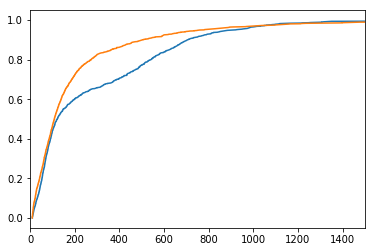

In [179]:
x,y = CDF(features_inside[:,10])
plt.plot(x,y)
x,y = CDF(features_outside[:,10])
plt.plot(x,y)
plt.xlim(0,1500)

In [170]:
features_sorted

['area',
 'height',
 'rotation',
 'DMVec9',
 'vert_std',
 'DMVec0',
 'DMVec1',
 'horiz_std',
 'DMVec4',
 'DMVec8',
 'width',
 'DMVec7',
 'DMVec2',
 'DMVec5',
 'mean',
 'DMVec3',
 'std']

In [171]:
choose = importances[structure]['area']
sorted(choose, key=choose.__getitem__, reverse=True)

['area*88', 'area*86', 'area*87', 'area*84', 'area*89', 'area*91', 'area*90']

In [150]:
importances[structure]['area']

{'area*88': 745.833282,
 'area*86': 411.316559,
 'area*87': 284.472748,
 'area*84': 198.141006,
 'area*89': 83.8743515,
 'area*91': 50.271965,
 'area*90': 44.512378690000006}

In [125]:
columns = np.array(columns)

In [126]:
%%time
fp = []
fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
X_train = []
y_train = []
for state in range(2):
    clouds = pickle.load(open(fp[state], 'rb'))
    X_train.extend(np.array(clouds))
    y_train.extend([1 - state] * len(clouds))

fp = []
fp.append(cell2_dir + structure + '/MD585_' + structure + '_positive.pkl')
fp.append(cell2_dir + structure + '/MD585_' + structure + '_negative.pkl')
for state in range(2):
    clouds = pickle.load(open(fp[state], 'rb'))
    X_train.extend(np.array(clouds))
    y_train.extend([1 - state] * len(clouds))
X_train = np.array(X_train)
y_train = np.array(y_train)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=columns)
bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

CPU times: user 18.7 s, sys: 478 ms, total: 19.1 s
Wall time: 7.72 s


In [64]:
columns[-1]

'density'

In [135]:
importances = {}
gains = bst.get_score(importance_type='total_gain')
importances[structure] = {}
for feature in gains.keys():
    if feature=='density':
        continue
    else:
        star = feature.rfind('*')
        name = feature[:star]
        if name not in importances[structure].keys():
            importances[structure][name] = {}
        importances[structure][name][feature] = gains[feature]
features = importances[structure].keys()
scores = {}
for feature in features:
    total = np.array([importances[structure][feature][name] for name in importances[structure][feature].keys()]).sum()
    scores[feature] = total
features_sorted = sorted(scores, key=scores.__getitem__, reverse=True)
for feature in features_sorted:
    for name in importances[structure][feature].keys():
        index = np.where(columns==name)[0][0]
        raw = index // 99
        col = index % 99
        

area*88 10 88
area*86 10 86
area*87 10 87
area*84 10 84
area*89 10 89
area*91 10 91
area*90 10 90
area*83 10 83
area*7 10 7
area*74 10 74
area*51 10 51
area*47 10 47
area*22 10 22
area*85 10 85
area*66 10 66
area*28 10 28
area*78 10 78
area*49 10 49
area*93 10 93
area*11 10 11
area*48 10 48
area*19 10 19
area*3 10 3
area*18 10 18
rotation*41 15 41
rotation*13 15 13
rotation*17 15 17
rotation*64 15 64
rotation*25 15 25
rotation*37 15 37
rotation*42 15 42
rotation*14 15 14
rotation*55 15 55
rotation*22 15 22
rotation*53 15 53
rotation*15 15 15
rotation*21 15 21
rotation*38 15 38
rotation*95 15 95
rotation*30 15 30
rotation*65 15 65
rotation*33 15 33
rotation*5 15 5
rotation*85 15 85
rotation*11 15 11
rotation*39 15 39
rotation*46 15 46
rotation*88 15 88
rotation*18 15 18
rotation*9 15 9
rotation*31 15 31
rotation*66 15 66
rotation*43 15 43
rotation*86 15 86
DMVec1*0 1 0
DMVec1*95 1 95
DMVec1*98 1 98
DMVec1*2 1 2
DMVec1*39 1 39
DMVec1*84 1 84
DMVec1*79 1 79
DMVec1*86 1 86
DMVec1*94 1 94
D

In [129]:
scores

{'area': 2093.99785642,
 'DMVec8': 369.23676853,
 'DMVec1': 412.98476642,
 'height': 374.302296969,
 'DMVec4': 249.882420637,
 'mean': 185.50069939999997,
 'DMVec2': 274.41250302490005,
 'rotation': 435.05910495,
 'std': 216.14634660500005,
 'DMVec9': 340.39929467,
 'horiz_std': 154.20615842,
 'width': 226.58974491,
 'DMVec5': 179.200472775,
 'DMVec0': 209.47829230899998,
 'DMVec3': 130.66170252700002,
 'vert_std': 194.81279561000002,
 'DMVec7': 205.03566453999997,
 'DMVec6': 120.232177252,
 'rotation_confidence': 153.549883587}

In [130]:
sorted(scores, key=scores.__getitem__, reverse=True)

['area',
 'rotation',
 'DMVec1',
 'height',
 'DMVec8',
 'DMVec9',
 'DMVec2',
 'DMVec4',
 'width',
 'std',
 'DMVec0',
 'DMVec7',
 'vert_std',
 'mean',
 'DMVec5',
 'horiz_std',
 'rotation_confidence',
 'DMVec3',
 'DMVec6']

In [181]:
for section in valid_sections:
    raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
    img_fn = raw_images_root + section_to_filename[section] + '_prep2_lossless_gray.tif'
    setup_download_from_s3(img_fn, recursive=False)

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOAD

In [184]:
valid_sections

array([94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       188, 189, 190, 191, 192, 194, 195, 196, 197, 198, 199, 200, 201,
       202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,
       215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227,
       228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 239, 240, 241,
       242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254,
       255, 256, 257, 258, 259, 260, 262, 263, 264, 265, 266, 267, 268,
       269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280